## **Capstone Project Draft**
**Student Group 7855**

**Tate Oliver Eldred, Yue Zhao (Student B)**

### Code Design Plan
1. Collect and clean daily data for the selected ETFs prices, volumes for the past 15 years (yfinance)
2. Setup ANN architecture for forecasting asset price returns
3. Setup LSTM-GARCH architecture for forecasting implied volatilities.
4. Use pypfopt package to compare the performance of baseline models to that of the forecasted prices and forecasted vol models
5. Perform backtesting and collect results

We collaborate on google collab and will migrate code to git repo as we finalize

https://github.com/dianaviolet/wqu-capstone/tree/tate

https://github.com/dianaviolet/wqu-capstone/tree/main

### Import Packages

In [ ]:
%%capture
#install packages
#!pip install -U git+https://github.com/emoen/Machine-Learning-for-Asset-Managers
!pip install pyportfolioopt
!pip install scikit-learn-extra
!pip install pandas_datareader
!pip install arch
!pip install pydot graphviz
!pip install keras_tuner
!pip install scikeras

In [ ]:
#import packages
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import requests
from itertools import combinations
import seaborn as sns
import pypfopt
from arch import arch_model
import pandas_datareader.data as web
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.stats.diagnostic import het_arch
import warnings
import contextlib
import io
import os
import pyperclip
from google.colab import drive
drive.mount('/content/drive')
warnings.filterwarnings('ignore')

from pypfopt.expected_returns import mean_historical_return, returns_from_prices
from pypfopt import base_optimizer
from pypfopt import black_litterman, risk_models
from pypfopt.risk_models import CovarianceShrinkage
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices
from pypfopt.black_litterman import BlackLittermanModel

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Input, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.utils import plot_model
import keras_tuner as kt
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV

Mounted at /content/drive


### Data Download

In [ ]:
# define the investable universe
np.random.seed(42)
tickers = ['AOM', 'VT', 'AGG', 'BIL', 'VDE', 'DBC','^VIX', 'AQMIX', 'IWN', 'SPY']

# define the investment horizon
start_dt ="2009-01-01"
end_dt ="2024-12-31"

# define the train/test/validation split
train_size = 0.7
valid_size = 0.1

sector_prices = yf.download(tickers=tickers, start=start_dt, end=end_dt, interval="1d")["Close"]
sector_volume = yf.download(tickers=tickers, start=start_dt, end=end_dt, progress=False)['Volume']
sector_returns = np.log(sector_prices).diff().dropna()*100

#train test split
def split_dataset(df, train_size, valid_size=0):
    train_end = int(df.shape[0] * train_size)
    valid_end = int(df.shape[0] * (train_size + valid_size))

    train_df = df.iloc[:train_end]
    test_df = df.iloc[valid_end:]
    if valid_size==0:
        return train_df, test_df
    else:
        valid_df = df.iloc[train_end:valid_end]
        return train_df, valid_df, test_df

train_prices, valid_prices, test_prices = split_dataset(sector_prices, train_size, valid_size)
train_returns, valid_returns, test_returns = split_dataset(sector_returns, train_size, valid_size)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  10 of 10 completed


#### Data Cleaning

In [ ]:
sector_prices.isna().sum()

,0
Ticker,
AGG,0
AOM,0
AQMIX,253
BIL,0
DBC,0
IWN,0
SPY,0
VDE,0
VT,0


In [ ]:
sector_prices = sector_prices.dropna()
sector_prices.to_csv('/content/drive/My Drive/sector_prices.csv')
sector_volume = sector_volume.dropna()
sector_prices.to_csv('/content/drive/My Drive/sector_volume.csv')
sector_returns = sector_returns.dropna()
sector_prices.to_csv('/content/drive/My Drive/sector_returns.csv')

In [ ]:
# download FF factors
rfr = yf.download("^IRX", start=start_dt, end=end_dt)["Close"].iloc[-1]/100
ff_factors = web.DataReader('F-F_Research_Data_Factors_daily', 'famafrench', start_dt, end_dt)[0]
ff_factors.index = pd.to_datetime(ff_factors.index, format='%Y%m%d')
ff_factors = ff_factors / 100
ff_data = sector_returns.join(ff_factors, how='inner')
ff_data['RF'] = ff_data['RF'].fillna(method='ffill')
excess_returns = ff_data[tickers].subtract(ff_data['RF'], axis=0)
sector_factors = ff_data[['Mkt-RF', 'SMB', 'HML']]

[*********************100%***********************]  1 of 1 completed


#### Exploratory Data Analysis

In [ ]:
def price_volume(tickers, df_price, df_volume):
    n_rows = int(np.ceil(len(tickers) / 3))
    fig, axs = plt.subplots(n_rows, 3, figsize=(20, 4 * n_rows), sharex=False)
    axs = axs.flatten()  # Flatten the array of axes for easy iteration

    for i, ax in enumerate(axs):
        if i < len(tickers):
            ticker = tickers[i]

            # Plot the closing prices
            ax.plot(df_price[ticker], label=ticker)
            ax.set_ylabel("Price")
            ax.tick_params(axis='y')
            ax.legend()

            # Plot the volume
            ax2 = ax.twinx()
            ax2.bar(df_volume[ticker].index, df_volume[ticker], alpha=0.7, color="gray", label="Volume")
            ax2.set_ylabel("Volume")
            ax2.tick_params(axis='y')

            ax.set_title(f'{ticker} Closing Prices and Volume')
            ax.grid(True)
        else:
            ax.axis('off')

    plt.tight_layout()
    plt.show()

# Volatilty Clustering
def volatility_clustering_analysis(tickers, time_series):
    n_rows = np.ceil(len(tickers)/3).astype(int)

    plt.figure(figsize=(20, 4*n_rows))
    for i, ticker in enumerate(tickers):
        # Calculate the daily returns
        #daily_returns = time_series[ticker].pct_change().dropna()
        plt.subplot(n_rows, 3, i+1)

        # Plot the daily returns
        plt.plot(time_series[ticker])
        plt.title(f'{ticker} Daily Returns (Volatility Clustering)')
        plt.xlabel('Date')
        plt.ylabel('Daily Returns')
        p_value = het_arch(time_series[ticker]*100)[1]
        plt.text(0.5, 0.9, f'ARCH Test p-value: {p_value:.3f}', ha='center', va='center', transform=plt.gca().transAxes)

    plt.tight_layout()
    plt.show()

# Return Distribtion
def plot_hist(tickers, time_series):

    n_rows = np.ceil(len(tickers)/3).astype(int)
    plt.figure(figsize=(20, 4*n_rows))
    for i, ticker in enumerate(tickers):
        plt.subplot(n_rows, 3, i+1)
        # Plot the daily returns
        time_series[ticker].hist(bins=50)
        kurtosis = time_series[ticker].kurt()
        skew = time_series[ticker].skew()
        plt.text(0.5, 0.9, f'Skew, Kurtosis: {skew:.2f}, {kurtosis:.2f}', ha='center', va='center', transform=plt.gca().transAxes)
        plt.title(f'{ticker} Daily Returns Histograms')
        plt.xlabel('Daily Returns')
        plt.ylabel('Count')

    plt.tight_layout()
    plt.show()

def corr_plot(df, target):
    plt.figure(figsize=(8,6))
    corr = df.corr()
    sort_index = corr[target].abs().sort_values(ascending=False).index
    corr = corr.loc[sort_index, sort_index]
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    mask = np.triu(np.ones_like(corr, dtype=np.bool_))
    heatmap = sns.heatmap(corr, mask = mask, cmap=cmap, vmin=-1, vmax=1, annot=True)
    heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=10)

def best_garch(daily_returns, max_p=5, max_o=2, max_q=5, dist_list=['normal', 't', 'skewt']):
    acf_list = acf(daily_returns, nlags=max_q)
    pacf_list = pacf(daily_returns, nlags=max_p)

    # Select lags where values exceed a significance threshold
    threshold = 1.96 / np.sqrt(len(daily_returns))
    sig_p = [int(p) for p in np.where(np.abs(acf_list) > threshold)[0] if p > 0]
    sig_q = [int(q) for q in np.where(np.abs(pacf_list) > threshold)[0] if q > 0]

    # Ensure at least one candidate for p and q
    p_list = sig_p or [1]
    q_list = sig_q or [1]

    best_model = None
    best_bic = np.inf

    for p in p_list:
        for q in q_list:
            for o in range(0,max_o):
                for dist in dist_list:
                    garch_model = arch_model(daily_returns, vol='garch', p=p, o=o, q=q, dist = dist)
                    with contextlib.redirect_stdout(io.StringIO()):
                        garch_fit = garch_model.fit(show_warning = False)
                    if garch_fit.bic < best_bic:
                        best_bic = garch_fit.bic
                        best_model = (p, q, o, dist)

    return best_model if best_model else (1, 1)

def plot_acf_pacf(tickers, time_series, best_garch_param):
    fig, axes = plt.subplots(len(tickers), 2, figsize=(10, 3 * len(tickers)))

    for i, ticker in enumerate(tickers):
        #daily_returns = time_series[ticker].pct_change().dropna()
        plot_acf(time_series[ticker]**2, ax=axes[i, 0])
        axes[i, 0].text(0.5, 0.9, f'Best (p,q, o, dist): {best_garch_param.get(ticker)}', ha='center', va='center', transform=axes[i, 0].transAxes)
        axes[i, 0].set_title(f'{ticker} ACF of Returns')
        plot_pacf(time_series[ticker]**2, ax=axes[i, 1])
        axes[i, 1].set_title(f'{ticker} PACF of Returns')

    plt.tight_layout()
    plt.show()

##### Price-Volume Plot

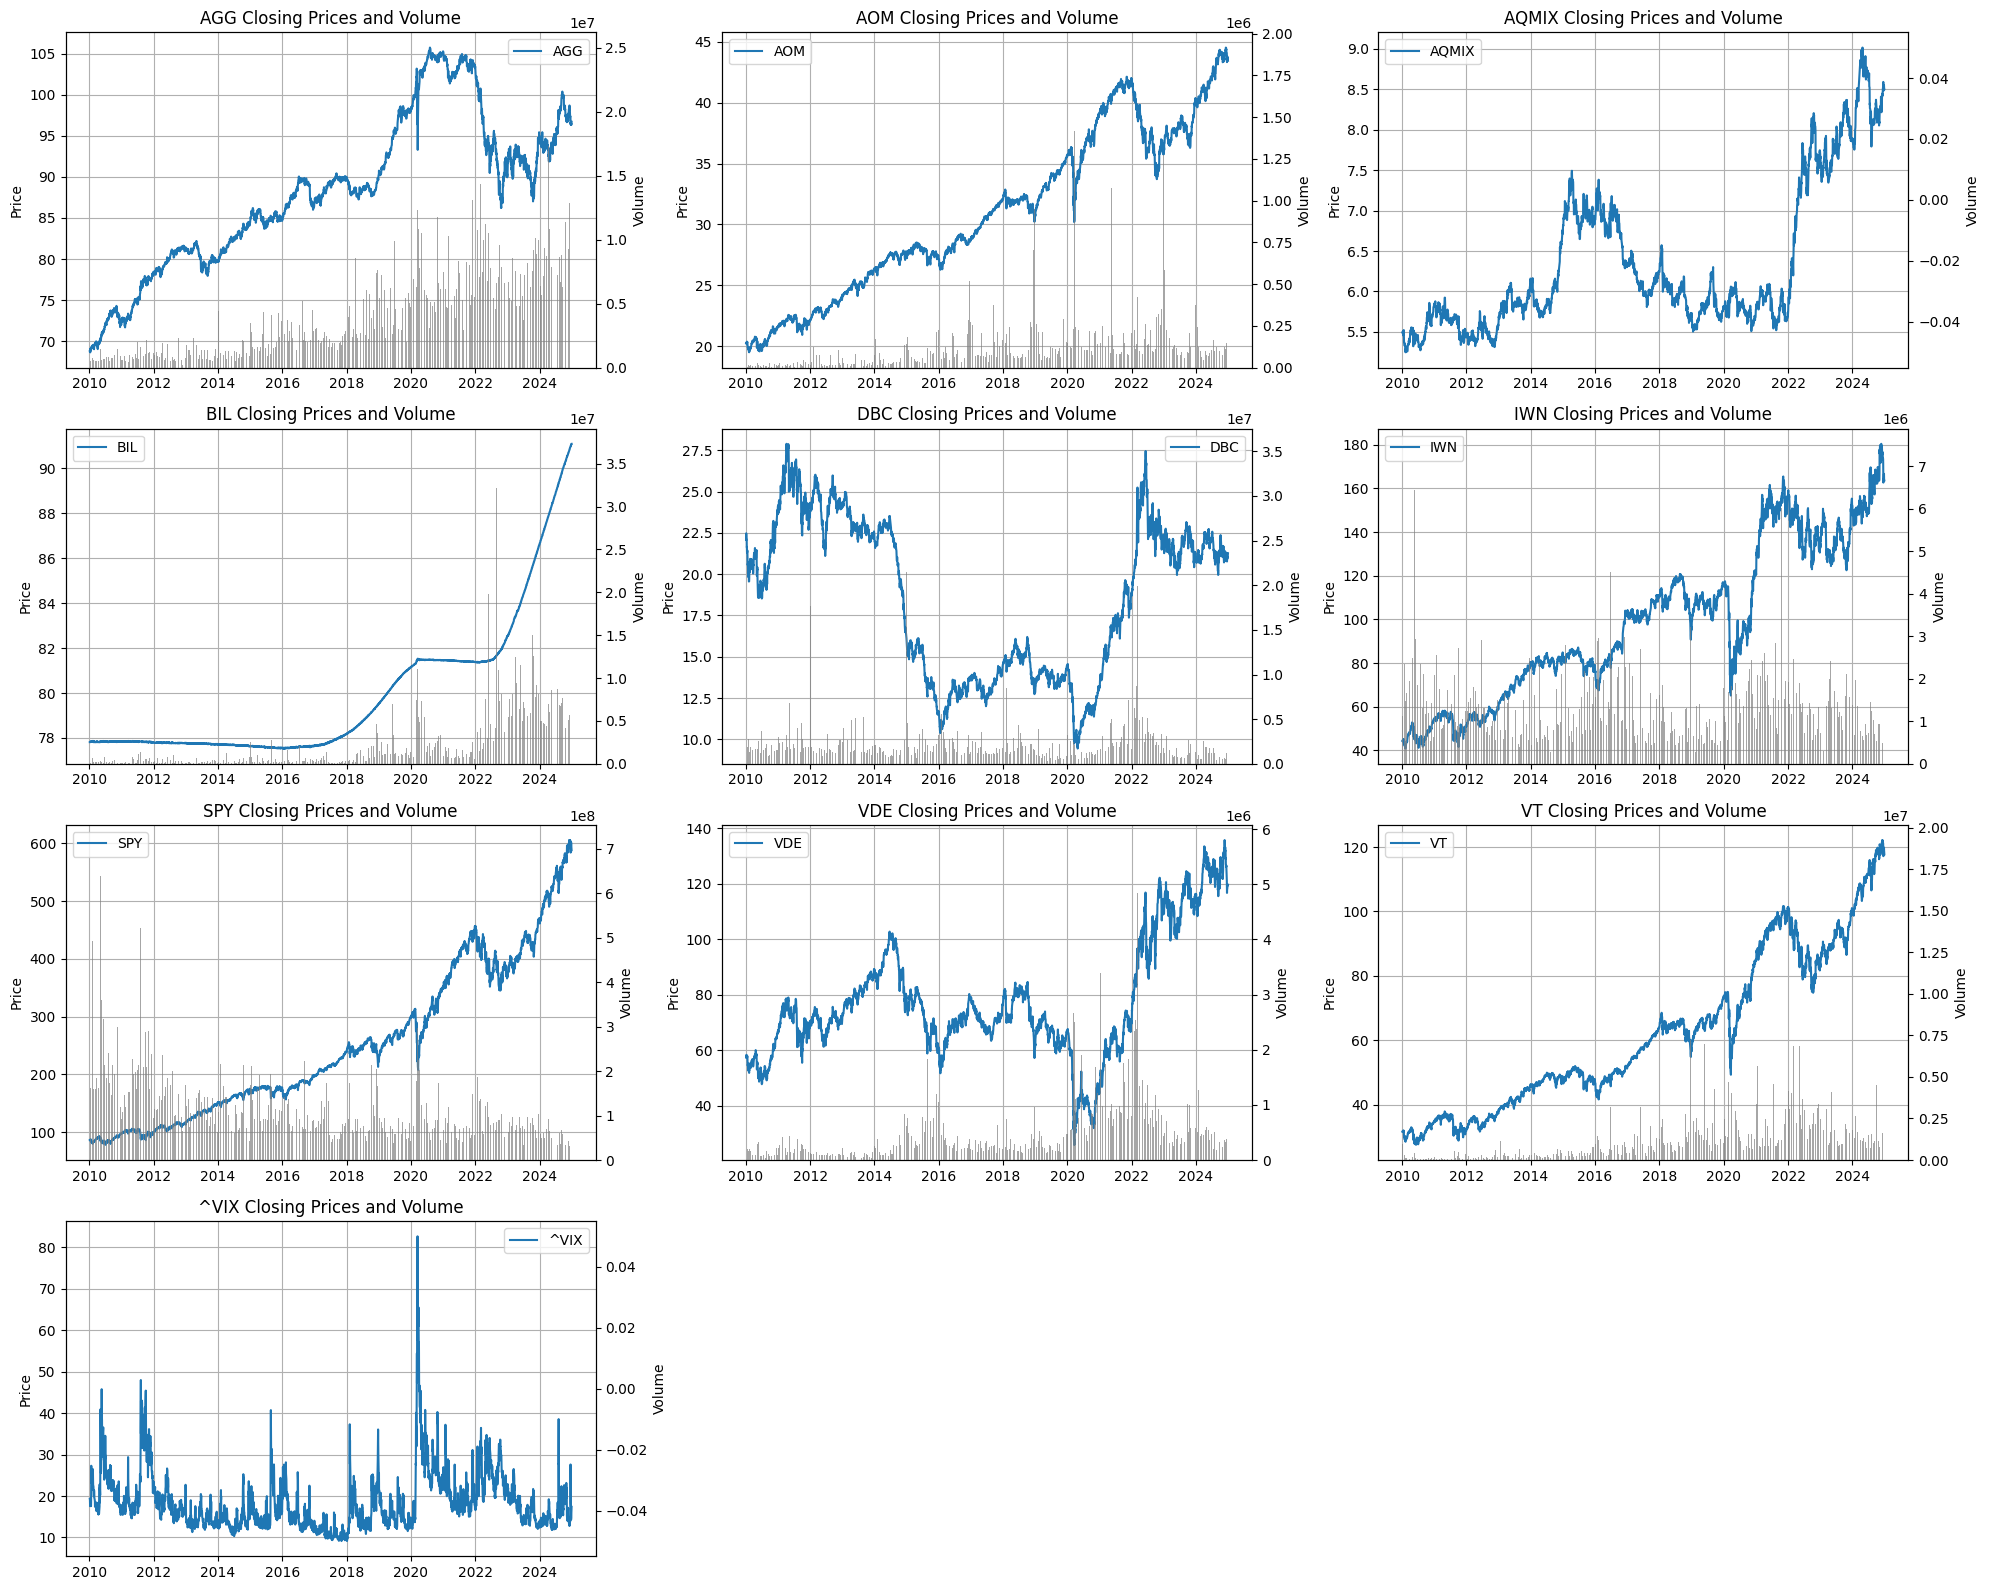

In [ ]:
price_volume(sector_prices.columns.to_list(), sector_prices, sector_volume)

##### Correlation Plot

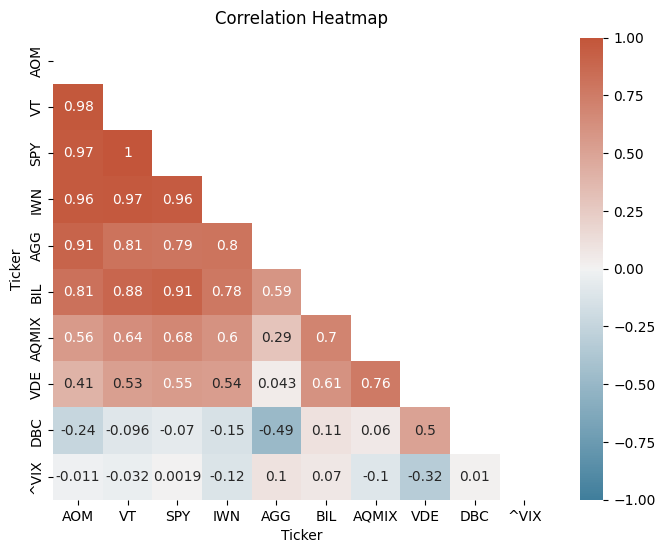

In [ ]:
corr_plot(sector_prices, tickers[0])

##### Volatility Clustering Plot

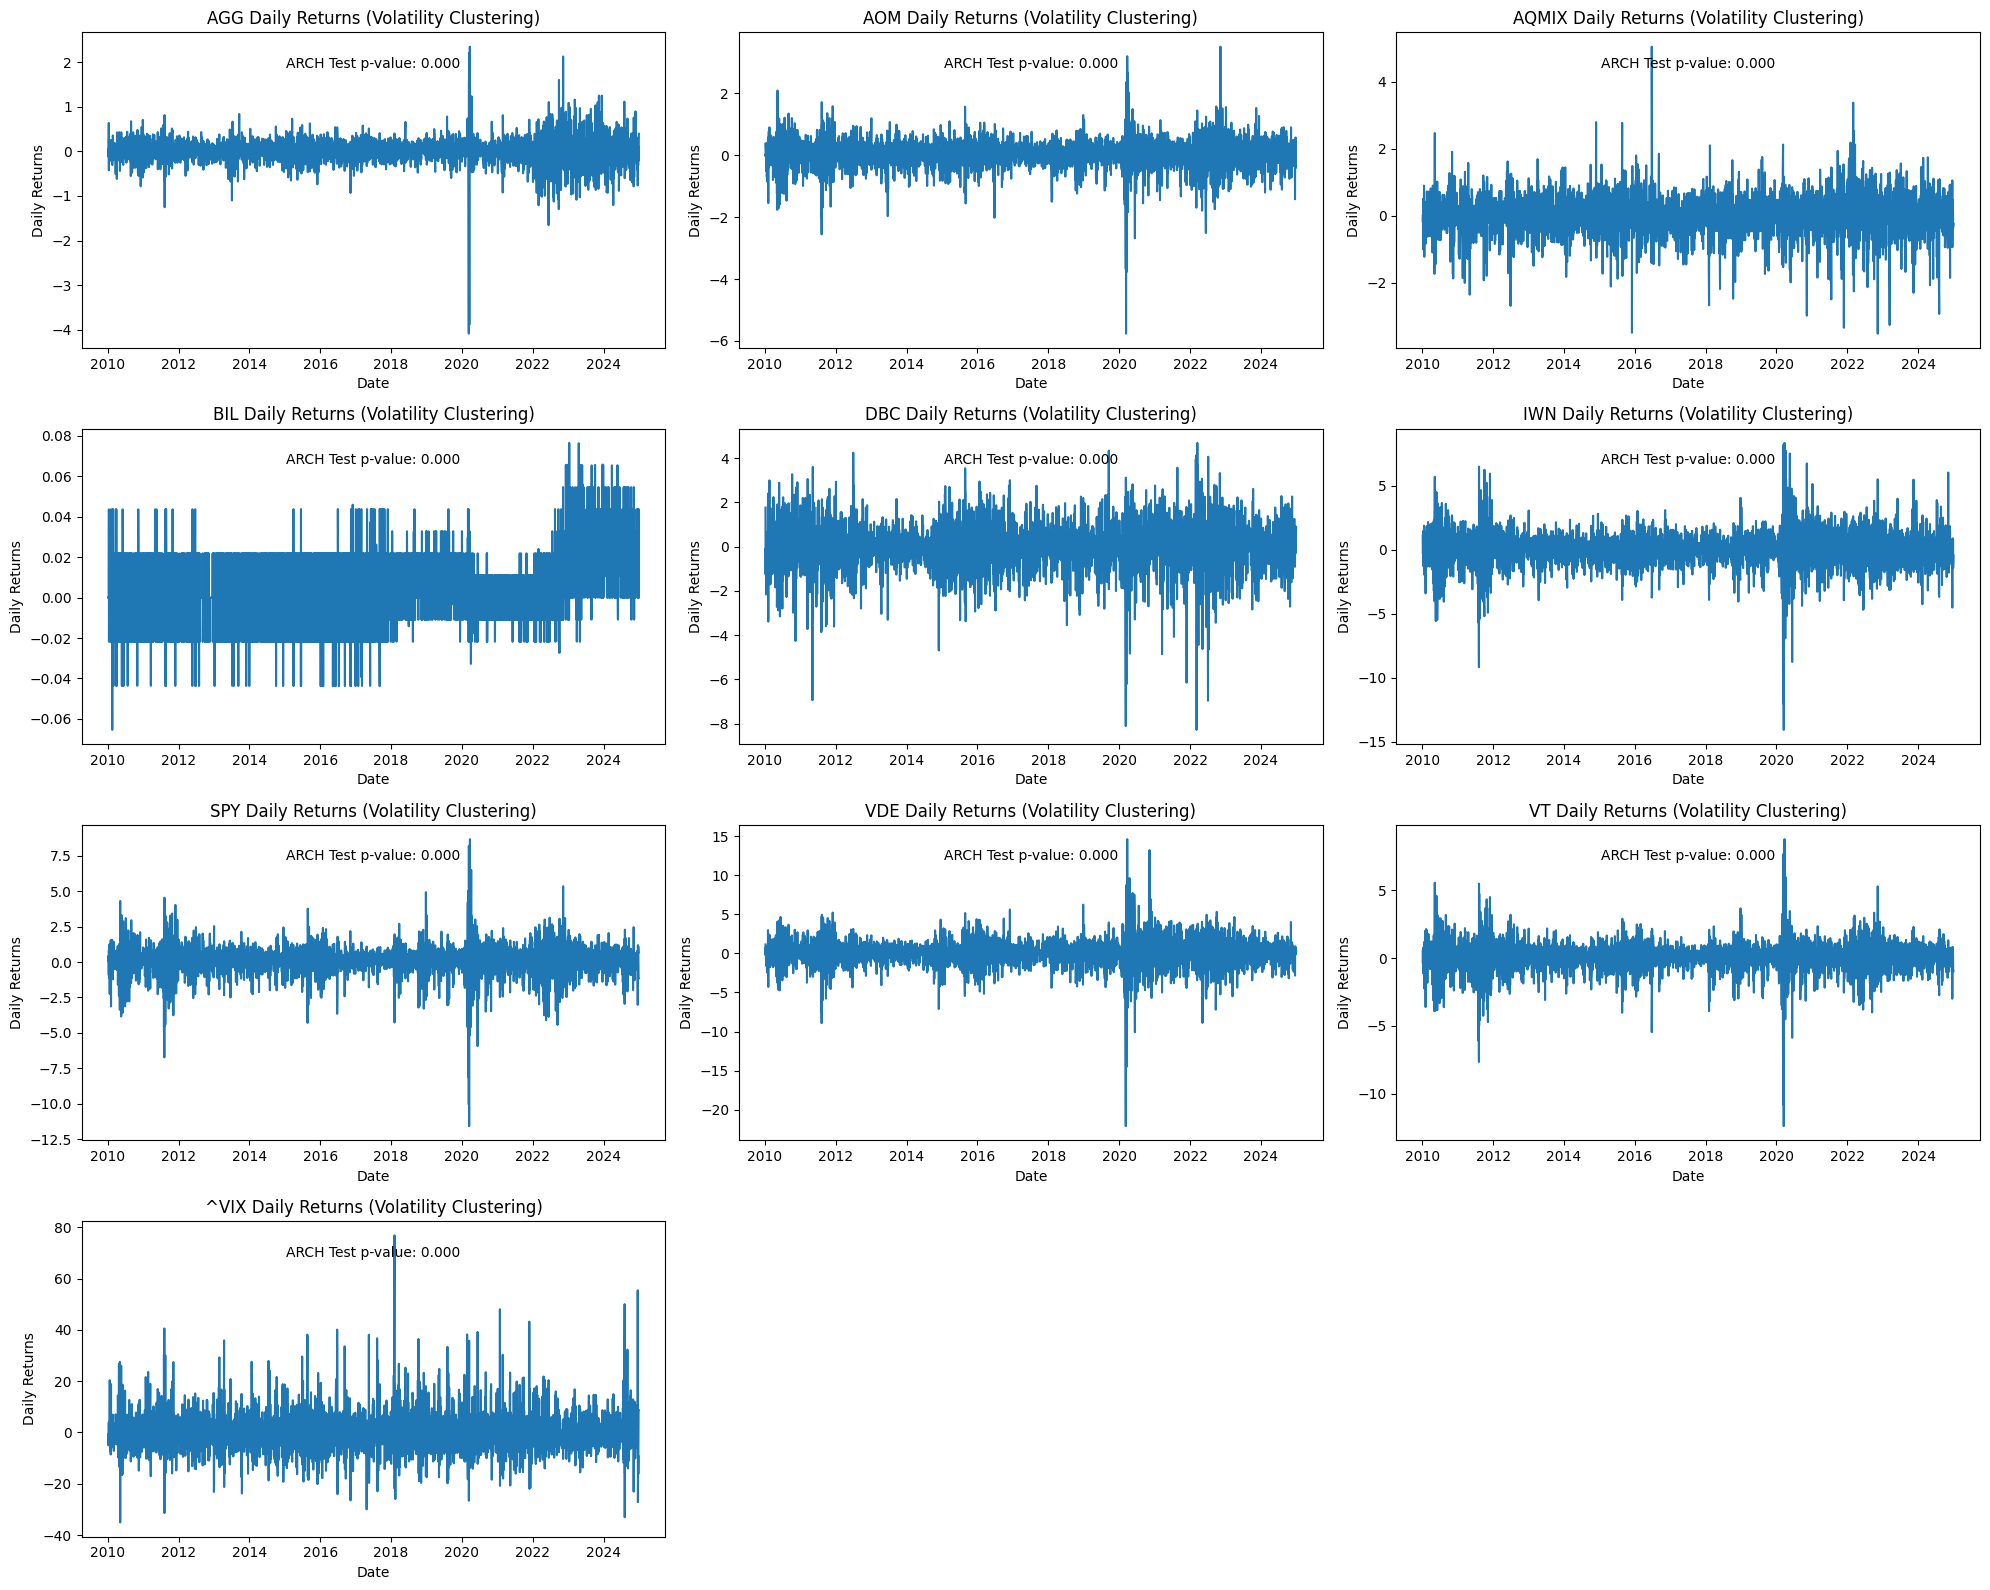

In [ ]:
volatility_clustering_analysis(sector_prices.columns.to_list(), sector_returns)

##### Return Distribution Historgram

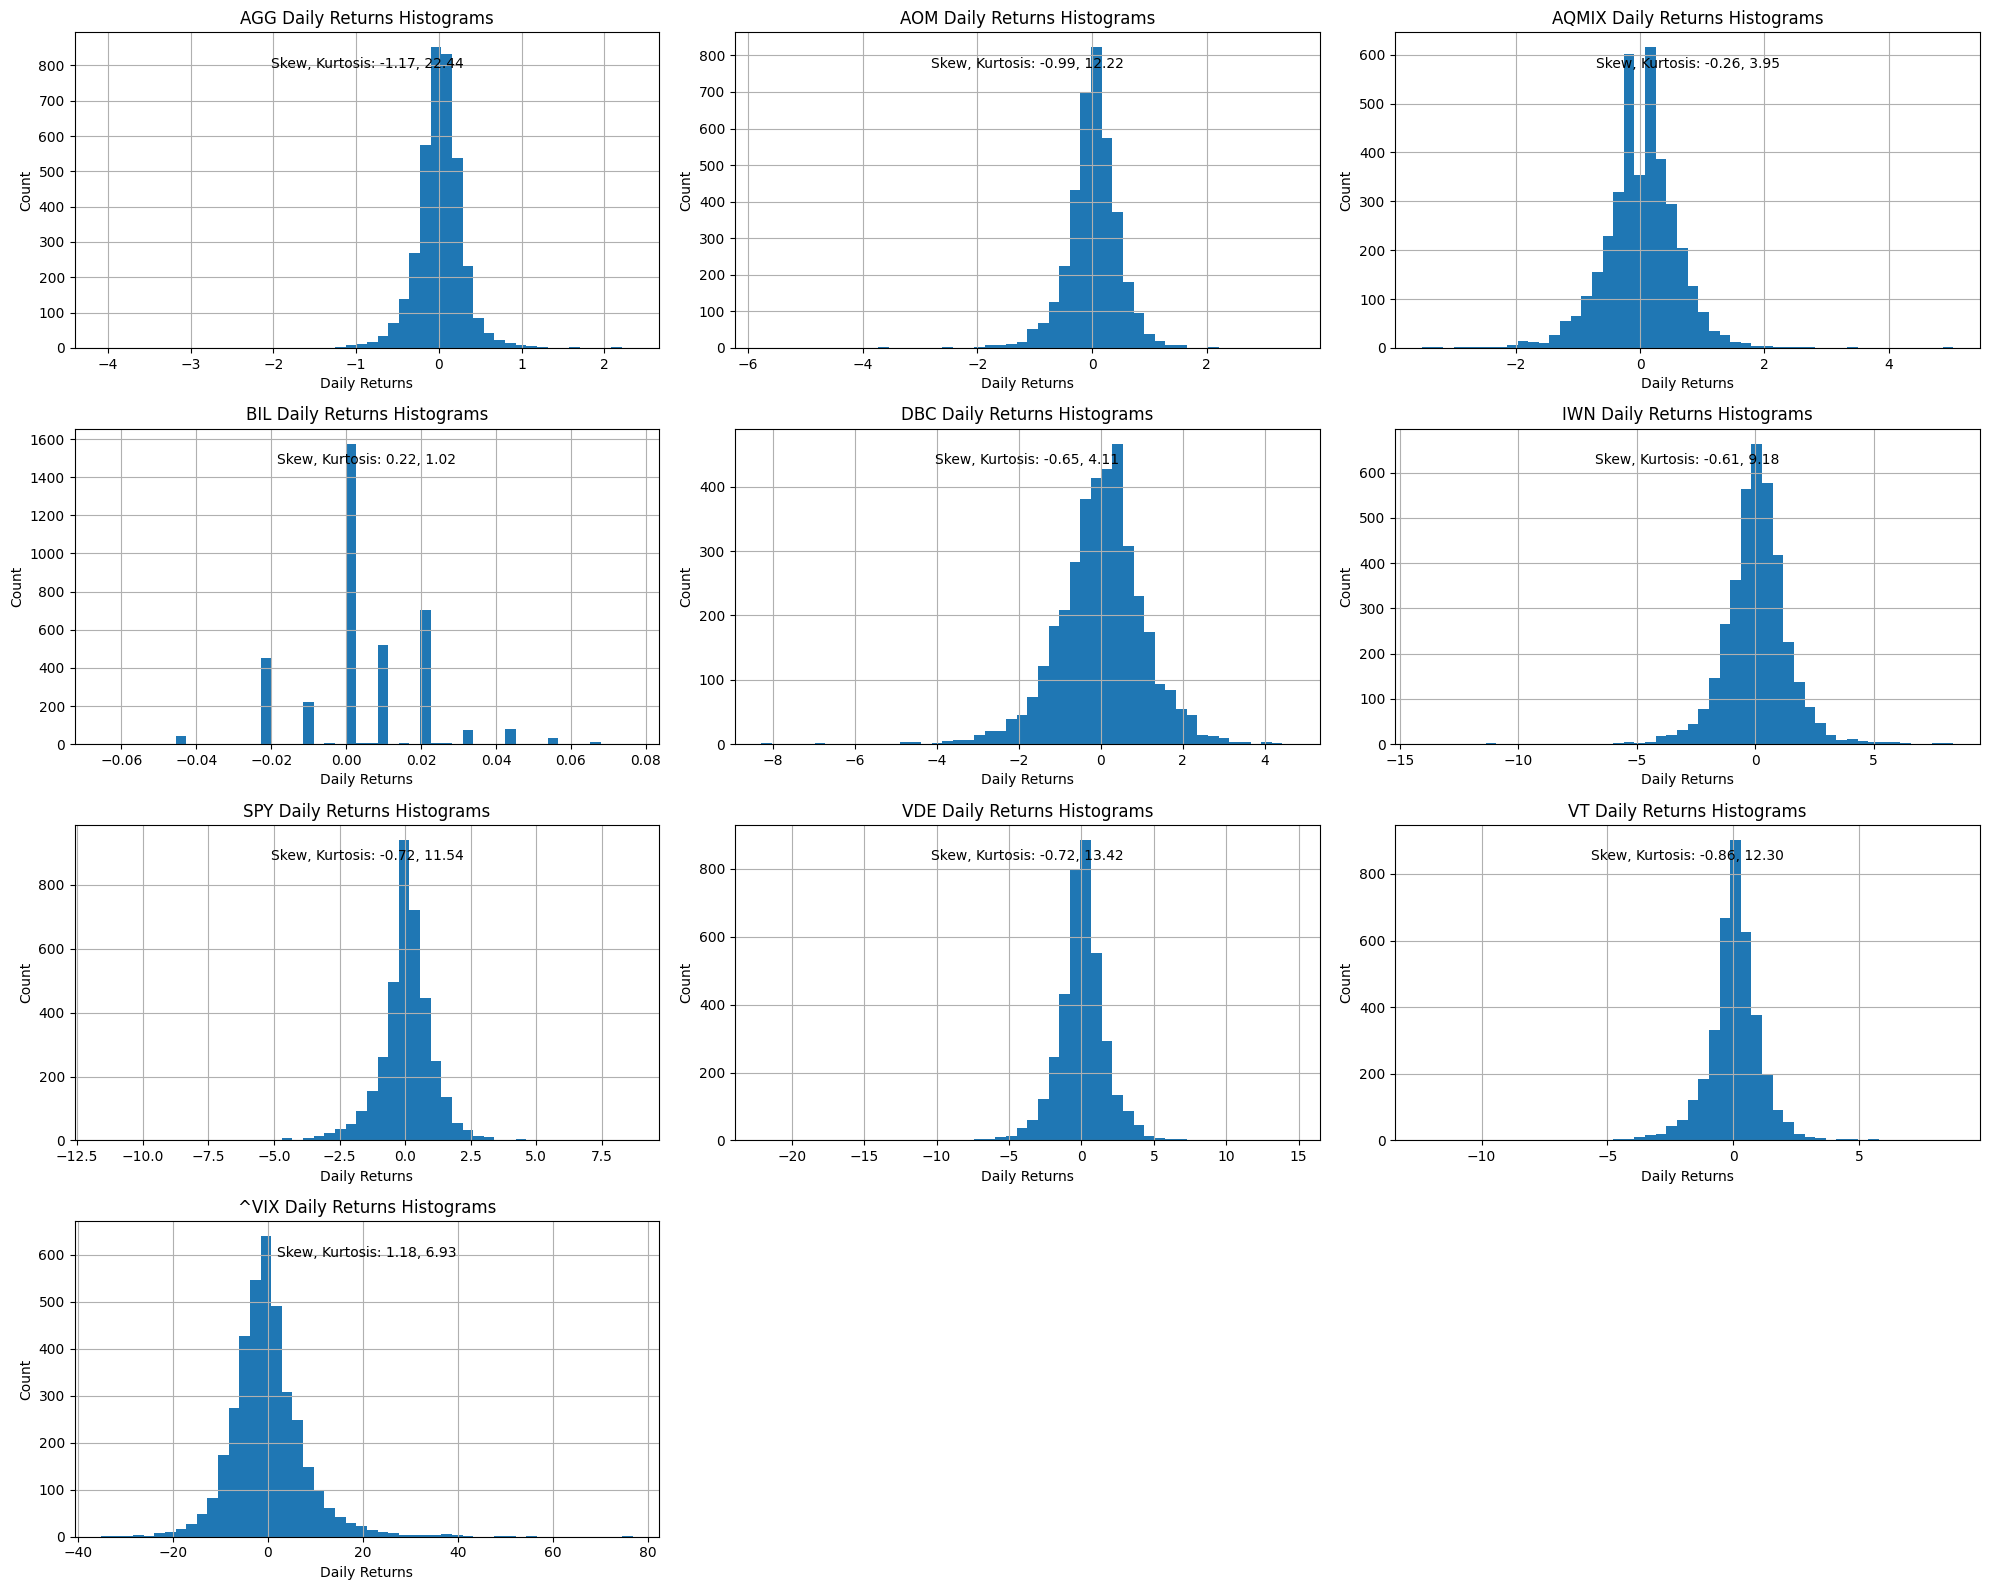

In [ ]:
plot_hist(sector_prices.columns.to_list(), sector_returns)

##### ACF and PACF Plots

In [ ]:
best_garch_params = {}
for ticker in sector_returns.columns:
    best_garch_params[ticker] = best_garch(sector_returns[ticker])
garch_params_df = pd.DataFrame.from_dict(best_garch_params, orient='index', columns=['p', 'q', 'o', 'dist'])
garch_params_df.to_csv('/content/drive/My Drive/garch_params.csv')

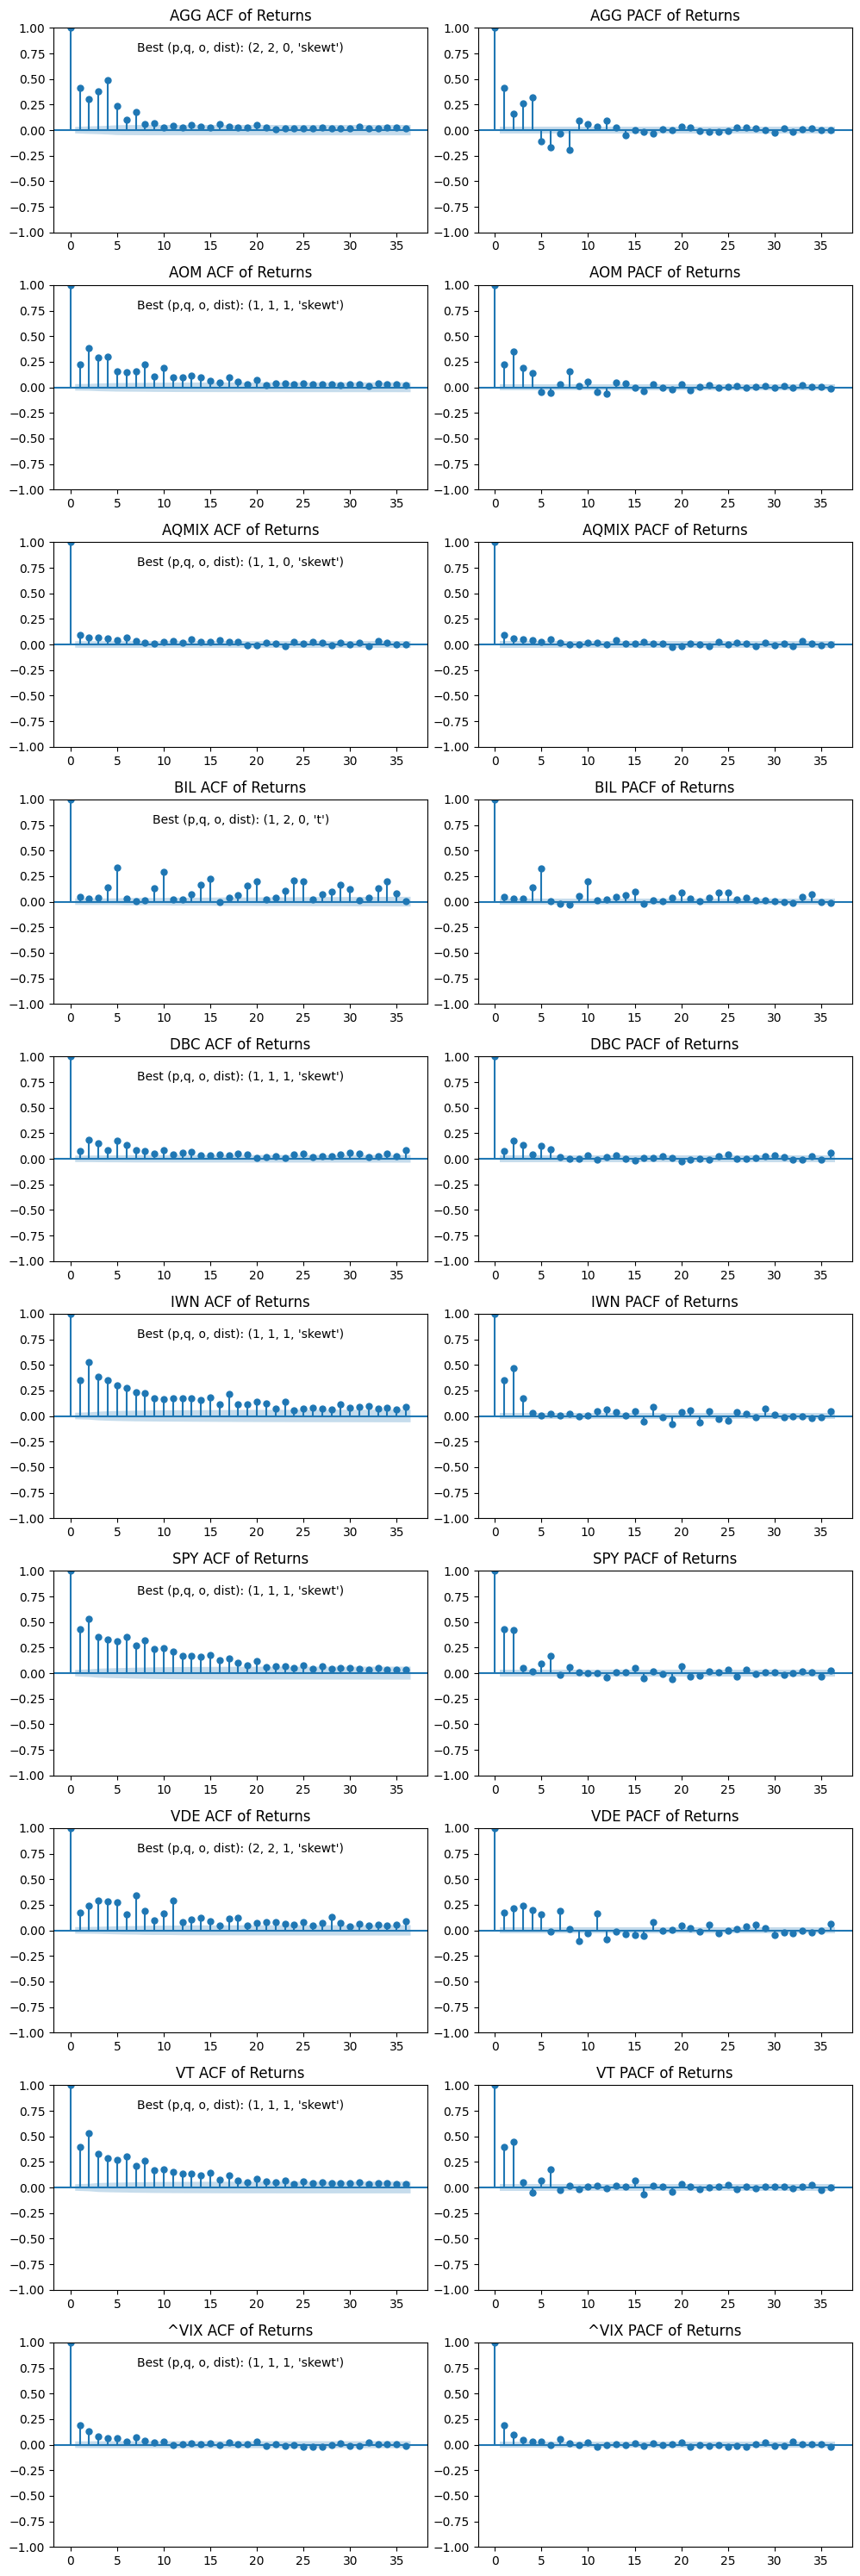

In [ ]:
plot_acf_pacf(sector_prices.columns.to_list(), sector_returns, best_garch_params)

### Baseline MVO - Benchmark

In [ ]:
#baseline MVO
class EfficientFrontierAllocation:
    def __init__(self, mu, cov_matrix, rfr=0.0):
        self.mu = mu
        self.cov_matrix = cov_matrix
        self.rfr = rfr

    def create_ef(self):
        ef = EfficientFrontier(self.mu, self.cov_matrix)
        return ef

    def optimize(self, optimization_method, *args, **kwargs):
        ef = self.create_ef()
        method = getattr(ef, optimization_method)
        weights = method(*args, **kwargs)
        clean_weights = {k: v for k, v in ef.clean_weights().items() if v > 0}
        performance = ef.portfolio_performance(risk_free_rate=self.rfr)
        return weights, clean_weights, performance

    def min_volatility(self):
        return self.optimize('min_volatility')

    def max_sharpe(self):
        return self.optimize('max_sharpe')

    def max_quadratic_utility(self, risk_aversion=1, market_neutral=False):
        return self.optimize('max_quadratic_utility', risk_aversion, market_neutral)

    def efficient_risk(self, target_vol):
        return self.optimize('efficient_risk', target_vol)

    def efficient_return(self, target_ret):
        return self.optimize('efficient_return', target_ret)

In [ ]:
#calculate expected returns and covariance matrix from pypfopt library
mu = mean_historical_return(train_prices).to_numpy()
cov_matrix = CovarianceShrinkage(train_prices).ledoit_wolf()
ef_portfolio = EfficientFrontierAllocation(mu, cov_matrix, rfr)

minvol_weights, minvol_clean_weights, (minvol_expret, minvol_vol, minvol_sharpe) = ef_portfolio.min_volatility()
maxsharpe_weights, maxsharpe_clean_weights, (maxsharpe_expret, maxsharpe_vol, maxsharpe_sharpe) = ef_portfolio.max_sharpe()
maxquad_weights, maxquad_clean_weights, (maxquad_expret, maxquad_vol, maxquad_sharpe) = ef_portfolio.max_quadratic_utility()
#effrisk_weights, effrisk_clean_weights, (effrisk_expret, effrisk_vol, effrisk_sharpe) = ef_portfolio.efficient_risk(target_volatility=DJI_vol)
#effret_weights, effret_clean_weights, (effret_expret, effret_vol, effret_sharpe) = ef_portfolio.efficient_return(target_return=DJI_return)

AttributeError: 'Series' object has no attribute 'value'

### Return Prediction

In [ ]:
# Standard library imports
import os
import time
import warnings
import logging
import datetime
from random import seed

# Third-party imports
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy import stats
import yfinance as yf
import talib
from talib import abstract

# Sklearn imports
from sklearn.preprocessing import (
    PowerTransformer,
    MinMaxScaler,
    StandardScaler,
    RobustScaler
)
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import TimeSeriesSplit, train_test_split

# Tensorflow imports
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (
    EarlyStopping,
    LearningRateScheduler,
    ReduceLROnPlateau,
    TensorBoard,
    ModelCheckpoint
)
from tensorflow.keras.layers import (
    Input,
    Dense,
    LSTM,
    GRU,
    Conv1D,
    MaxPooling1D,
    Flatten,
    TimeDistributed,
    concatenate,
    Dropout,
    LayerNormalization,
    Bidirectional
)

# Suppress warnings
warnings.filterwarnings('ignore')

# Set up logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler('model_training.log'),
        logging.StreamHandler()
    ]
)

# Constants
TICKERS = [
    "SPY",
    "AOM",
    "VT",
    "AGG",
    "^VIX",
    "VDE",
    "DBC",
    "AQMIX",
    "IWN"
]
START_DATE = "2009-01-01"
END_DATE = "2024-12-31"

# Download data
res_data = yf.download(
    TICKERS,
    start=START_DATE,
    end=END_DATE,
    group_by='Ticker'
)

def Indicator(Data):
    """Calculates technical indicators using TA-Lib."""
    data = Data.copy()
    lagged_data = data.shift(1)
    talib_functions = talib.get_function_groups()
    indicators = [ind for group in talib_functions for ind in talib_functions[group]]
    problematic_indicators = {'MAVP', 'OBV'}
    indicators = [ind for ind in indicators if ind not in problematic_indicators]

    for indicator_name in indicators:
        try:
            indicator_info = abstract.Function(indicator_name)
            input_names, output_names = indicator_info.input_names, indicator_info.output_names
            indicator_func = getattr(talib, indicator_name)

            if len(output_names) == 1:
                kwargs = {}
                for input_name in input_names:
                    if isinstance(input_name, str):
                        input_key = input_name.lower()
                    else:
                        input_key = [name.lower() for name in input_name]

                    if isinstance(input_key, str):
                        if input_key in lagged_data.columns:
                            kwargs[input_key] = lagged_data[input_key]
                        elif input_key == 'price':
                            if 'close' in lagged_data:
                                kwargs['price'] = lagged_data['close']
                        elif input_key == "real" and 'volume' in lagged_data.columns.str.lower():
                            kwargs['real'] = lagged_data['Volume']
                    elif isinstance(input_key, list):
                        all_present = all(k in lagged_data.columns for k in input_key)
                        if all_present:
                            kwargs.update({k: lagged_data[k] for k in input_key})

                if kwargs and len(kwargs) >= len([x for x in input_names if isinstance(x,str)]):
                    new_col = indicator_func(**kwargs)
                    if isinstance(new_col, (pd.Series, np.ndarray)):
                        data[f'{indicator_name}'] = new_col
                    elif isinstance(new_col, list):
                        if len(new_col) == len(output_names):
                            for i, out_name in enumerate(output_names):
                                data[f'{indicator_name}_{out_name}'] = pd.Series(new_col[i], index=data.index)

        except Exception as e:
            print(f"Error calculating {indicator_name}: {e}")
            continue

    cols_to_remove = [col for col in data.columns if data[col].isnull().tail(len(data) - 1).any() or not np.isfinite(data[col]).all()]
    data.drop(columns=cols_to_remove, inplace=True, errors='ignore')
    return data

def add_lag(data, col, lag_list):
    """Adds lagged columns."""
    df = data.copy()
    for lag in lag_list:
        df[f'{col}_lag_{lag}'] = df[col].shift(lag)
    return df

def add_diff(data, col):
    """Calculates the difference."""
    df = data.copy()
    df[f'{col}_difference'] = df[col].diff()
    df[f'{col}_difference'].fillna(0, inplace=True)
    return df

def Roll_Stats(data, col, Roll_Window):
    """Calculates rolling statistics."""
    df = data.copy()
    lag = 1
    col_val = df[col].shift(lag)
    for window in Roll_Window:
        if not isinstance(window, int) or window <= 0:
            print("Roll_Window must contain positive integers")
            continue
        rolled = col_val.rolling(window=window)
        df[f'{col}_mean_lag_{lag}_win_{window}'] = rolled.mean()
        df[f'{col}_std_lag_{lag}_win_{window}'] = rolled.std()
        df[f'{col}_max_lag_{lag}_win_{window}'] = rolled.max()
        df[f'{col}_min_lag_{lag}_win_{window}'] = rolled.min()
        df[f'{col}_diff_lag_{lag}_win_{window}'] = rolled.max() - rolled.min()
    return df

def Prepare_Data(data, col, Lag_list, Roll_window):
    """Combines features."""
    if min(Roll_window) < 2:
        raise ValueError('Roll_window must be greater than 1.')
    df = data.copy()
    df = add_lag(df, col, Lag_list)
    df = Roll_Stats(df, col, Roll_window)
    df = add_diff(df, col)
    return df

def Combine(Data, col, Lag_list, Roll_window):
    """Prepares data for multiple columns."""
    data = pd.DataFrame({col: Data[col]}, index=Data.index)
    data = Prepare_Data(data, col, Lag_list, Roll_window)
    for c in ['Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close']:
        if c != col:
            temp_df = Prepare_Data(pd.DataFrame(Data[c]), c, Lag_list, Roll_window)
            data = pd.concat([data, temp_df], axis=1)
    return data

#--------------- Corrected Mutual Information --------------
def mutual_information_lag(data, target_col, k_best):
    """
    Calculates mutual information and selects top k features.

    Args:
        data (pd.DataFrame): Input data
        target_col (str): Target column name
        k_best (int): Number of top features to select

    Returns:
        tuple: (selected_columns, sorted_mutual_info_scores)
    """
    try:
        data_copy = data.copy().dropna()
        if data_copy.empty:
            raise ValueError("No data left after dropping NA values")

        mic_ordered = {}
        seed(21)

        for col in data_copy.columns:
            if col != target_col:
                col_val = data_copy[col].values
                if np.std(col_val) > 0:
                    col_val = np.clip(col_val, -1e6, 1e6)
                    score = mutual_info_regression(
                        col_val.reshape(-1, 1),
                        data_copy[target_col].values.ravel()
                    )
                    mic_ordered[col] = score[0]
                else:
                    logging.warning(f"Column {col} has zero standard deviation - skipping")

        if not mic_ordered:
            raise ValueError("No valid features found for mutual information calculation")

        sorted_mic = dict(sorted(mic_ordered.items(), key=lambda item: item[1], reverse=True))
        selected_col = list(sorted_mic.keys())[:k_best]
        return selected_col, sorted_mic

    except Exception as e:
        logging.error(f"Error in mutual_information_lag: {str(e)}")
        raise

#---------------- Corrected Final Data Preparation -------------
def Final_Data_Preparation(Data, col, Lag_list, Roll_window, features=None):
    """Combines all data preparation steps."""
    # Drop NA *BEFORE* combining, so all columns have same length
    data = Data.copy().dropna()

    data = Combine(data, col, Lag_list, Roll_window)
    df = Indicator(data) # Pass the combined data *without* indicator.
    data = pd.concat([df, data], axis=1) # Now the created indicators are added
    data.dropna(inplace=True)
    data = data.loc[:,~data.columns.duplicated()].copy()

    if features == None:
        MIC = mutual_information_lag(data, col, Data.columns.shape[0])
        selected_features = [feature for feature in list(MIC[1].keys())[:300]]
    else:
        selected_features = features
    final_columns = selected_features + [col]  # Keep target
    data = data[final_columns].dropna()
    return data, selected_features

data_dict = {}
for ticker in TICKERS[:1]:
    data_dict[f'{ticker}'], features = Final_Data_Preparation(res_data[f'{ticker}'],'Adj Close',[i for i in range(1,30)],[i for i in range(2,60)])
for ticker in TICKERS[1:]:
    data_dict[f'{ticker}'], features = Final_Data_Preparation(res_data[f'{ticker}'],'Adj Close',[i for i in range(1,30)],[i for i in range(2,60)], features)

def train_test_split_chronological(df, test_size=0.1):
  """
  Splits data into training and testing sets chronologically.
  """
  split_index = int(len(df) * (1 - test_size))
  df_train = df.iloc[:split_index]
  df_test = df.iloc[split_index:]
  return df_train, df_test

train_dict = {}
val_dict = {}
test_dict = {}

for ticker in data_dict.keys():
    train_dict[f'{ticker}'], val_temp = train_test_split_chronological(data_dict[f'{ticker}'], test_size=0.1)
    val_dict[f'{ticker}'], test_dict[f'{ticker}'] = train_test_split_chronological(val_temp, test_size=0.5)

def create_target(df, forward_days=300, thresholds=(-0.05, -0.01, 0.01, 0.05)):
    """Creates a multi-class target variable."""
    df = df.copy()
    future_return = (df['Adj Close'].shift(-forward_days) / df['Adj Close']) - 1
    df['target'] = pd.cut(future_return,
                           bins=[-np.inf, thresholds[0], thresholds[1], thresholds[2], thresholds[3], np.inf],
                           labels=['highly_negative', 'slightly_negative', 'flat', 'slightly_positive', 'highly_positive'])
    df.dropna(inplace=True)
    y = pd.DataFrame(index=df.index)
    y['target'] = df.pop('target')
    y = pd.DataFrame(y)
    return df, y

X_train_dict = {}
y_train_dict = {}
X_val_dict = {}
y_val_dict = {}
X_test_dict = {}
y_test_dict = {}

for ticker in data_dict.keys():
    X_train_dict[f'{ticker}'], y_train_dict[f'{ticker}'] = create_target(train_dict[f'{ticker}'])
    X_val_dict[f'{ticker}'], y_val_dict[f'{ticker}'] = create_target(val_dict[f'{ticker}'])
    X_test_dict[f'{ticker}'], y_test_dict[f'{ticker}'] = create_target(test_dict[f'{ticker}'])

def create_cnn_lstm_gru_model(input_shape, lstm_units=32, gru_units=16,  # Reduced units
                             conv_filters=16, kernel_size=1, pool_size=2,  # Simplified CNN
                             dropout_rate=0.2, use_layer_norm=True, use_bidirectional=False): #Increased dropout
    """Creates a CNN-LSTM-GRU model (simplified)."""
    input_layer = Input(shape=input_shape)

    # CNN part (shared)
    cnn_part = TimeDistributed(Conv1D(filters=conv_filters, kernel_size=kernel_size, activation='relu'))(input_layer)
    cnn_part = TimeDistributed(MaxPooling1D(pool_size=pool_size))(cnn_part)
    cnn_part = TimeDistributed(Flatten())(cnn_part)

    # LSTM branch
    lstm_branch = LSTM(lstm_units, return_sequences=True)(cnn_part)
    if use_layer_norm:
        lstm_branch = LayerNormalization()(lstm_branch)
    lstm_branch = Dropout(dropout_rate)(lstm_branch)  # Dropout after LayerNorm
    if use_bidirectional:
        lstm_branch = Bidirectional(LSTM(lstm_units))(lstm_branch)  # Bidirectional LSTM
    else:
        lstm_branch = LSTM(lstm_units)(lstm_branch) #Regular LSTM

    # GRU branch
    gru_branch = GRU(gru_units, return_sequences=True)(cnn_part)
    if use_layer_norm:
        gru_branch = LayerNormalization()(gru_branch)
    gru_branch = Dropout(dropout_rate)(gru_branch)    # Dropout after LayerNorm
    if use_bidirectional:
        gru_branch = Bidirectional(GRU(gru_units))(gru_branch)  # Bidirectional GRU
    else:
        gru_branch = GRU(gru_units)(gru_branch)


    # Concatenate
    merged = concatenate([lstm_branch, gru_branch])
    if use_layer_norm:
        merged = LayerNormalization()(merged)  # LayerNorm after concatenate
    merged = Dropout(dropout_rate)(merged)       # Dropout after concatenate

    # Output layer
    output_layer = Dense(5, activation='categorical_crossentropy')(merged)

    model = Model(inputs=input_layer, outputs=output_layer)
    return model

def reshape_data(data, n_steps, subsequences):

    if data.ndim == 2:
        data = data.reshape((data.shape[0], data.shape[1], 1))
    elif data.ndim != 3:
        raise ValueError("Input data must be 2D (samples, timesteps) or 3D (samples, timesteps, features)")

    n_samples = data.shape[0]
    n_features = data.shape[2]
    timesteps_per_subsequence = n_steps // subsequences

    if n_steps % subsequences != 0:
        raise ValueError(f"n_steps ({n_steps}) must be divisible by subsequences ({subsequences}).")
    if n_steps > data.shape[1]:
        raise ValueError(f"n_steps ({n_steps}) cannot be greater than the number of timesteps in the data ({data.shape[1]})")

    # Correct reshaping
    reshaped_data = data[:, :n_steps, :].reshape((n_samples, subsequences, timesteps_per_subsequence, n_features))
    return reshaped_data


def scale_data(X_train_df, X_val_df, X_test_df, scaler_type='power'):

    if scaler_type == 'power':
        scaler = PowerTransformer()
    elif scaler_type == 'minmax':
        scaler = MinMaxScaler()
    elif scaler_type == 'standard':
        scaler = StandardScaler()
    elif scaler_type == 'robust':
        scaler = RobustScaler()
    else:
        raise ValueError("Invalid scaler_type. Choose from 'power', 'minmax', 'standard', 'robust'.")

    # Fit the scaler on the training data *only*
    X_train_scaled = scaler.fit_transform(X_train_df.values)

    # Transform the validation and test data using the fitted scaler
    X_val_scaled = scaler.transform(X_val_df.values)
    X_test_scaled = scaler.transform(X_test_df.values)

    return X_train_scaled, X_val_scaled, X_test_scaled, scaler


def train_evaluate_model(X_train_df, y_train_df, X_val_df, y_val_df, X_test_df, y_test_df,
                        n_steps, subsequences, epochs=50, batch_size=32, scaler_type='standard',
                        learning_rate=1e-4, patience=10, dropout_rate=0.35,
                        use_layer_norm=True, use_bidirectional=False, verbose=0,
                        n_splits=15, test_size=100):
    """
    Trains and evaluates the model using walk-forward validation.

    Args: ... (document all parameters)
    Returns: ... (document return values)
    """
    start_time = time.time()
    logging.info("Starting model training")

    try:
        # Scale and reshape data
        X_train, X_val, X_test, x_scaler = scale_data(X_train_df, X_val_df, X_test_df, scaler_type)
        y_scaler = PowerTransformer()
        y_train = y_scaler.fit_transform(y_train_df.values.reshape(-1, 1)).flatten()
        y_val = y_scaler.transform(y_val_df.values.reshape(-1, 1)).flatten()
        y_test = y_scaler.transform(y_test_df.values.reshape(-1, 1)).flatten()

        # Initialize results containers
        results = {'fold_metrics': [],'fold_histories': [],'predictions': [],'actuals': []}

        # Walk-forward validation
        tscv = TimeSeriesSplit(n_splits=n_splits, test_size=test_size)
        for fold, (train_idx, val_idx) in enumerate(tscv.split(X_train)):
            fold_start = time.time()
            logging.info(f"Training fold {fold + 1}/{n_splits}")

            # ... rest of fold training code ...

            # Memory management
            clear_memory()

            fold_time = time.time() - fold_start
            logging.info(f"Fold {fold + 1} completed in {fold_time:.2f}s")

        total_time = time.time() - start_time
        logging.info(f"Training completed in {total_time:.2f}s")

        return final_model, y_pred, y_test_inv, results

    except Exception as e:
        logging.error(f"Error in train_evaluate_model: {str(e)}")
        raise

def calculate_metrics(y_true, y_pred):
    """Calculate comprehensive performance metrics."""
    return {'mse': mean_squared_error(y_true, y_pred),'mae': mean_absolute_error(y_true, y_pred),'rmse': np.sqrt(mean_squared_error(y_true, y_pred)),'mape': np.mean(np.abs((y_true - y_pred) / y_true)) * 100,'directional_accuracy': np.mean((y_true[1:] - y_true[:-1]) * (y_pred[1:] - y_pred[:-1]) > 0)}

def validate_input_data(X_train_df, y_train_df, X_val_df, y_val_df, X_test_df, y_test_df):
    """Validate input data before processing."""
    if any(df is None for df in [X_train_df, y_train_df, X_val_df, y_val_df, X_test_df, y_test_df]):
        raise ValueError("Input DataFrames cannot be None")

    if any(df.empty for df in [X_train_df, y_train_df, X_val_df, y_val_df, X_test_df, y_test_df]):
        raise ValueError("Input DataFrames cannot be empty")

    if any(df.isnull().any().any() for df in [X_train_df, y_train_df, X_val_df, y_val_df, X_test_df, y_test_df]):
        raise ValueError("Input DataFrames contain NaN values")

def validate_config(config):
    """Validate configuration parameters."""
    required_params = {'n_steps': (int, lambda x: x > 0),'subsequences': (int, lambda x: x > 0),'epochs': (int, lambda x: x > 0),'batch_size': (int, lambda x: x > 0),'learning_rate': (float, lambda x: 0 < x < 1),'patience': (int, lambda x: x > 0),'dropout_rate': (float, lambda x: 0 <= x < 1),'n_splits': (int, lambda x: x > 0),'test_size': (int, lambda x: x > 0)}

    for param, (param_type, validator) in required_params.items():
        if param not in config:
            raise ValueError(f"Missing required parameter: {param}")
        if not isinstance(config[param], param_type):
            raise TypeError(f"{param} must be of type {param_type}")
        if not validator(config[param]):
            raise ValueError(f"Invalid value for {param}")

def clear_memory():
    """Clear memory between processing different tickers."""
    import gc
    gc.collect()
    tf.keras.backend.clear_session()

def model_diagnostics(model, history, predictions, actuals):
    """Generate comprehensive model diagnostics."""
    diagnostics = {'convergence': {
            'final_loss': history['loss'][-1],
            'loss_trend': np.diff(history['loss']).mean(),
            'early_stopped': len(history['loss']) < model.epochs
        },'performance': calculate_metrics(actuals, predictions),'residuals': {'mean': np.mean(actuals - predictions),'std': np.std(actuals - predictions),'normality': stats.normaltest(actuals - predictions)}}
    return diagnostics

def visualize_model_diagnostics(model_diagnostics, save_path=None):
    """
    Visualizes model diagnostics including residuals and performance metrics.

    Args:
        model_diagnostics (dict): Dictionary containing model diagnostics
        save_path (str, optional): Path to save the plots
    """
    plt.figure(figsize=(15, 10))

    # Plot residuals
    plt.subplot(2, 2, 1)
    residuals = model_diagnostics['residuals']['values']
    plt.hist(residuals, bins=50)
    plt.title('Residuals Distribution')

    # Plot Q-Q plot
    plt.subplot(2, 2, 2)
    stats.probplot(residuals, dist="norm", plot=plt)
    plt.title('Q-Q Plot')

    # Plot metrics over time
    plt.subplot(2, 2, 3)
    metrics = model_diagnostics['performance']
    plt.bar(metrics.keys(), metrics.values())
    plt.title('Performance Metrics')
    plt.xticks(rotation=45)

    if save_path:
        plt.savefig(save_path)
    plt.show()

# --- Example Usage ---
if __name__ == '__main__':
    try:
        # Load configuration
        config = load_config('config.yaml')  # Consider using a config file
        validate_config(config)

        # Initialize results container
        results = initialize_results_container()

        # Process each ticker
        for ticker in data_dict.keys():
            ticker_start = time.time()
            logging.info(f"\nProcessing {ticker}")

            try:
                # Validate input data
                validate_input_data(X_train_dict[f'{ticker}'], y_train_dict[f'{ticker}'],X_val_dict[f'{ticker}'], y_val_dict[f'{ticker}'],X_test_dict[f'{ticker}'], y_test_dict[f'{ticker}'])

                # Train and evaluate
                (results['models'][ticker], results['predictions'][ticker],results['actuals'][ticker],results['training_histories'][ticker]) = train_evaluate_model(X_train_dict[f'{ticker}'], y_train_dict[f'{ticker}'],X_val_dict[f'{ticker}'], y_val_dict[f'{ticker}'],X_test_dict[f'{ticker}'], y_test_dict[f'{ticker}'],**config)

                # Create predictions DataFrame
                results['predictions_dfs'][ticker] = pd.DataFrame({'pred_price': results['predictions'][ticker],
                                                         'act_price': y_test_dict[f'{ticker}']['target'],
                                                         'Adj Close': X_test_dict[f'{ticker}']['Adj Close']}, index=X_test_dict[f'{ticker}'].index)

                results['predictions_dfs'][ticker]['pred_10d_ret'] = (results['predictions_dfs'][ticker]['pred_price'] / results['predictions_dfs'][ticker]['Adj Close']) - 1
                results['predictions_dfs'][ticker]['act_10d_ret'] = (results['predictions_dfs'][ticker]['act_price'] / results['predictions_dfs'][ticker]['Adj Close']) - 1
                results['predictions_dfs'][ticker]['pred_10d_ret_cat'] = pd.cut(results['predictions_dfs'][ticker]['pred_10d_ret'], [-np.inf, -0.05, -0.01, 0.01, np.inf], labels=False)
                results['predictions_dfs'][ticker]['act_10d_ret_cat'] = pd.cut(results['predictions_dfs'][ticker]['act_10d_ret'], [-np.inf, -0.05, -0.01, 0.01, np.inf], labels=False)
                print(results['predictions_dfs'][ticker])

                # Save results
                save_results(results, ticker)

                ticker_time = time.time() - ticker_start
                logging.info(f"{ticker}: Training completed in {ticker_time:.2f}s")

            except Exception as e:
                logging.error(f"Error processing {ticker}: {str(e)}")
                continue

            finally:
                clear_memory()

    except Exception as e:
        logging.error(f"Fatal error in main execution: {str(e)}")
        raise

### Volatility Forecast

#### GARCH Models

We select GARCH, EGARCH and GJR-GARCH models and compare the results based on 4 metrics: MSE, RMSE, MAE and MAPE. The best performing model is selected to be incorporated into the LSTM model.

##### GARCH Model Construction

In [ ]:
class GARCHModel:
    def __init__(self, model_type):
        self.model_type = model_type

    def metrics(self, obs, predict):
        mse = np.mean((obs - predict) ** 2)
        rmse = np.sqrt(mse)
        mae = np.mean(np.abs(obs - predict))
        mape = np.mean(np.abs((obs - predict) / np.where(obs != 0, obs, np.nan))) * 100
        return mse, rmse, mae, mape

    def build_model(self, ax1, ax2, ticker, p, q, o, dist, returns):
        train_df, test_df = split_dataset(returns, 0.8)

        model = arch_model(returns, vol=self.model_type, p=p, o=o, q=q, dist=dist)
        fit = model.fit(disp='off', show_warning=False, last_obs=train_df.index[-1])

        # Get conditional volatility
        cond_vol = fit.conditional_volatility
        forecast = fit.forecast(horizon=1, start=train_df.index[-1], align='target')

        train_perf = self.metrics(train_df.abs(), cond_vol.loc[train_df.index])
        test_perf = self.metrics(test_df.abs(), np.sqrt(forecast.variance[1:].values.flatten()))

        ax1.plot(cond_vol.loc[train_df.index], label=f'{self.model_type} Conditional Volatility')
        if o==0:
            ax1.plot(train_df.abs(), label='Abs Daily Returns', color='grey', alpha=0.3)
        ax1.set_title(f'{ticker} {self.model_type} Volatility')
        ax1.set_xlabel('Date')
        ax1.set_ylabel('Volatility')
        ax1.legend()

        ax2.plot(np.sqrt(forecast.variance[1:]), label=f'{self.model_type} Volatility Forecast')
        if o==0:
            ax2.plot(test_df.abs(), label='Abs Daily Returns', color='grey', alpha=0.3)
        ax2.set_title(f'{ticker} Volatility OOH Forecast')
        ax2.set_xlabel('Date')
        ax2.set_ylabel('Volatility')
        ax2.legend()

        #for i, (metric, val) in enumerate(zip(["MSE", "RMSE", "MAE", "MAPE"], train_perf)):
        #    ax1.text(0.02, 0.95 - i*0.05, f'{metric}: {val:.3f}', transform=ax1.transAxes, verticalalignment='top')
        #for i, (metric, val) in enumerate(zip(["MSE", "RMSE", "MAE", "MAPE"], test_perf)):
        #    ax2.text(0.02, 0.95 - i*0.05, f'{metric}: {val:.2f}', transform=ax2.transAxes, verticalalignment='top')

        return fit, train_perf, test_perf, cond_vol, np.sqrt(forecast.variance[1:])

##### GARCH Model Fitting

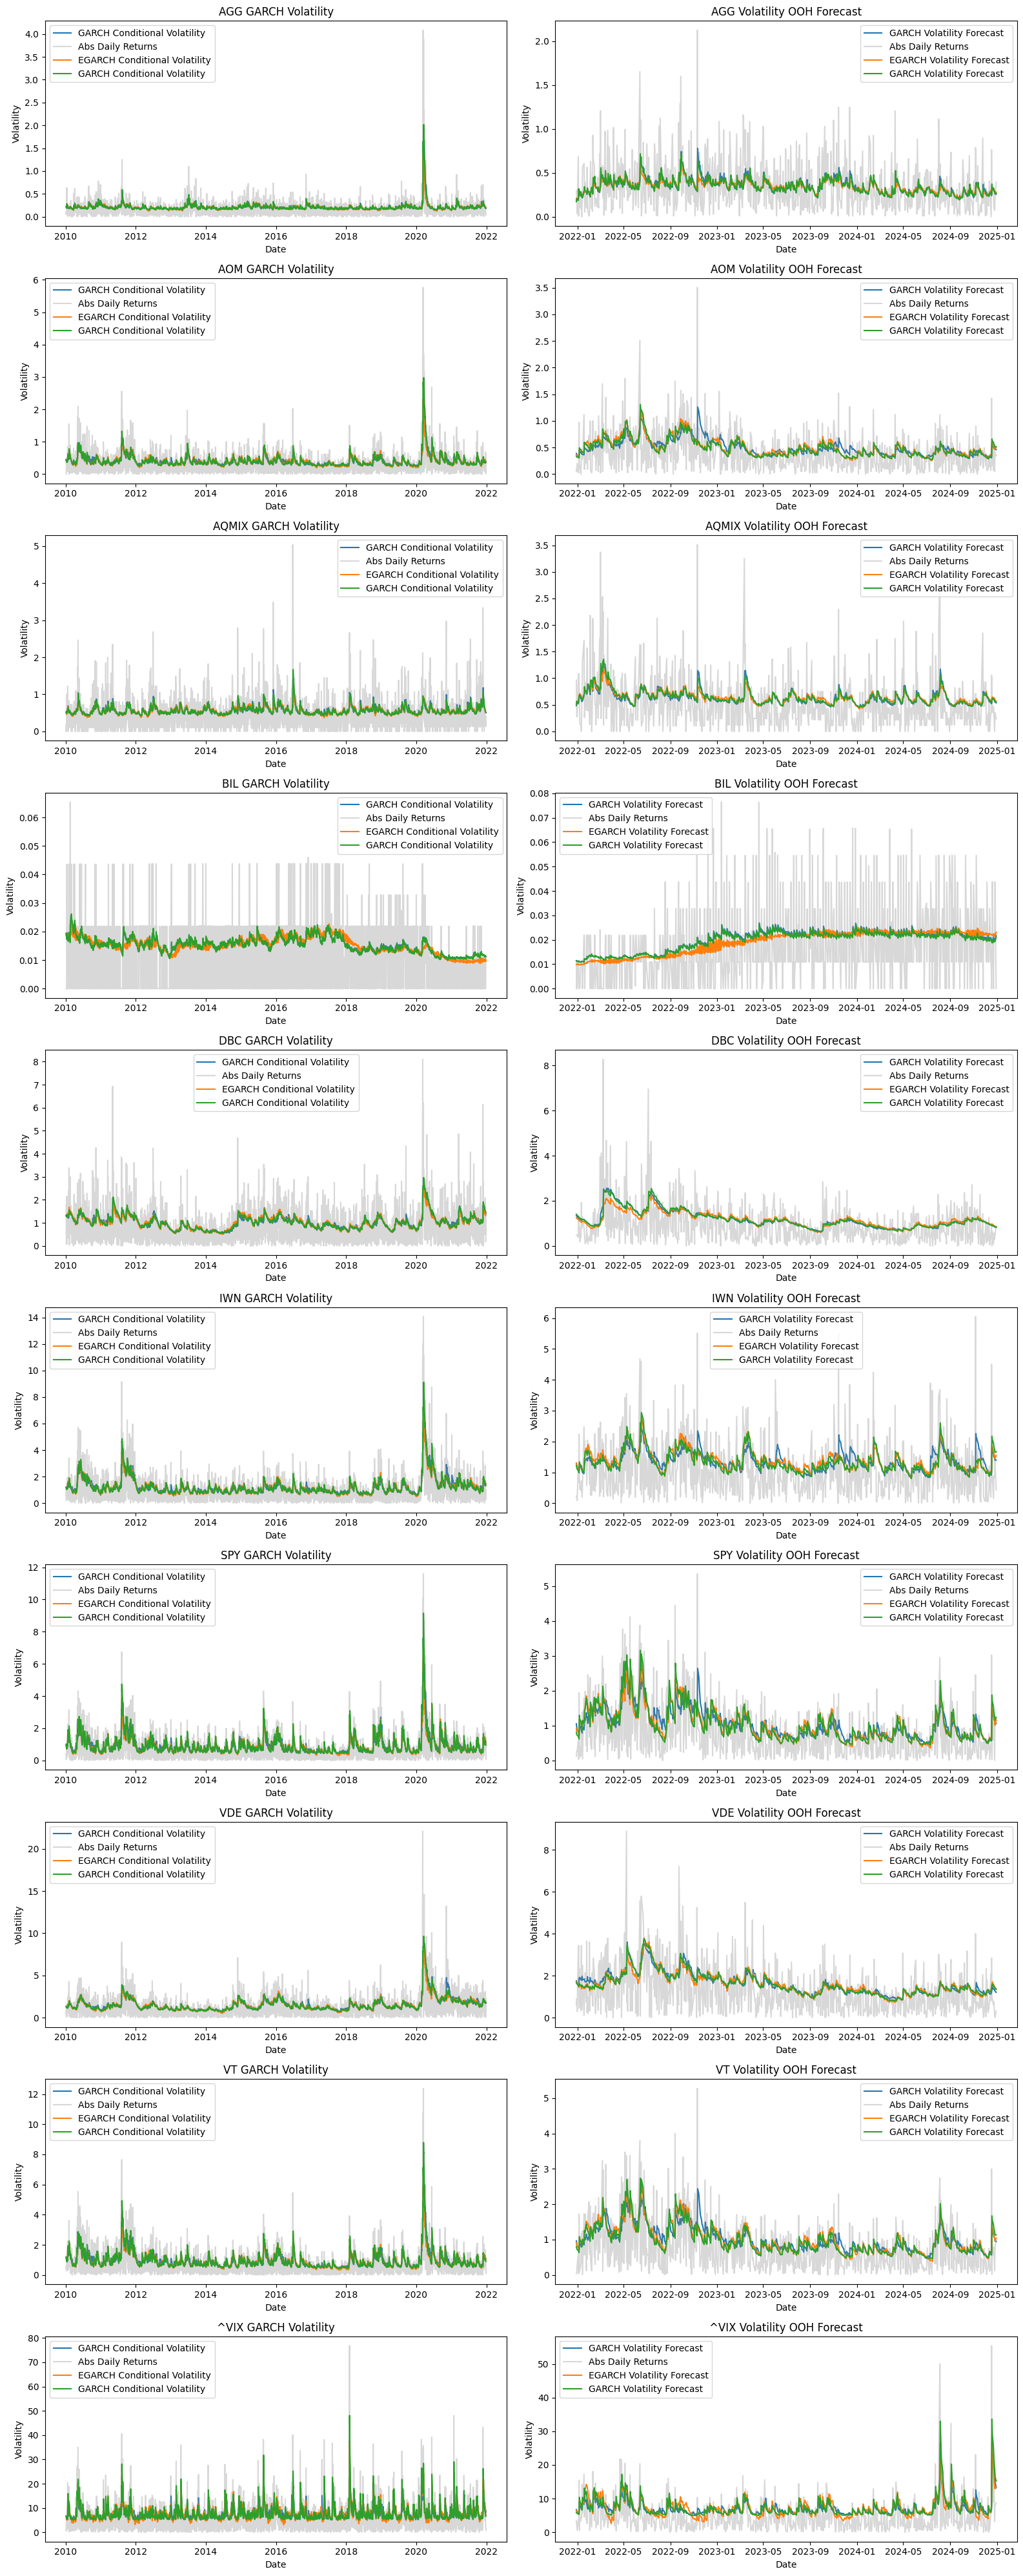

In [ ]:
results = []
garch_res = {}
n_rows = len(sector_prices.columns.to_list())
fig, axs = plt.subplots(n_rows, 2, figsize=(16, 4 * n_rows), sharex=False)

garch = {"GARCH": GARCHModel("GARCH"), "EGARCH": GARCHModel("EGARCH"), "GJR-GARCH": GARCHModel("GARCH")}
for i, ticker in enumerate(sector_prices.columns.to_list()):
    (p, q, o, dist) = best_garch_params.get(ticker)
    ax1 = axs[i, 0]
    ax2 = axs[i, 1]
    garch_res[ticker] = {}
    for name, model in garch.items():
        o = 0 if name == "GARCH" else 1
        fit, train_perf, test_perf, cond_vol, forecast = model.build_model(ax1, ax2, ticker, p, q, o, dist, sector_returns[ticker])
        results.append([ticker, name, 'Train', *train_perf])
        results.append([ticker, name, 'Test', *test_perf])
        garch_res[ticker][name] = {"cond_vol": cond_vol, "forecast": forecast}

plt.tight_layout()
plt.show()

##### GARCH Model Performances

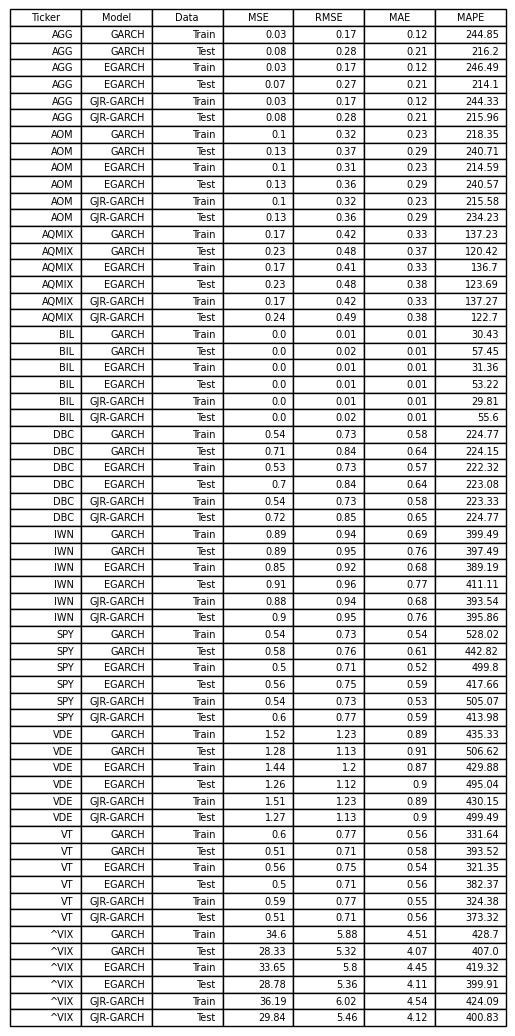

In [ ]:
garch_perf = pd.DataFrame(results, columns=['Ticker', 'Model', 'Data', 'MSE', 'RMSE', 'MAE', 'MAPE']).round(2)
garch_perf.to_csv('/content/drive/My Drive/garch_model_performances.csv')
fig, ax = plt.subplots()
fig.patch.set_visible(False)
ax.axis('off')
ax.table(cellText=garch_perf.values, colLabels=garch_perf.columns, loc='center')
fig.tight_layout()
plt.show()

##### GARCH Model Predictions

In [ ]:
egarch_vol = {}
for ticker in tickers:
    cond_vol = garch_res[ticker]['EGARCH']["cond_vol"].dropna()
    forecast = garch_res[ticker]['EGARCH']["forecast"]
    egarch_vol[ticker] = pd.concat([cond_vol, forecast.iloc[:,0]], axis=0).rename('EGARCH')

pd.DataFrame.from_dict(egarch_vol).to_csv('/content/drive/My Drive/garch_model_forecast.csv')

#### LSTM Models

We ran the LSTM model below on SPY with tuning to select the best hyperprameters with minimal validation loss (MSE). Then the selected model structure is used to train and fit all tickers for both LSTM model and the hybrid LSTM-GARCH model.

##### LSTM Model Construction

In [ ]:
class LSTMHyperparameterTuner:
    def __init__(self, act_fun='relu', seed=1234, window_size=30, max_epochs=50,
                 lstm_units=(16, 49), dropout_rate=(0.1, 0.2), lstm_layers=(0, 2),
                 dense_layers=(0, 2), learning_rate=(1e-4, 5e-4)):
        self.act_fun = act_fun
        self.seed = seed
        self.window_size = window_size
        self.max_epochs = max_epochs
        self.model = None
        self.scaler_input = None
        self.scaler_output = None
        self.tuner = None
        self.n_features = None
        self.X_train = None
        self.y_train = None
        self.X_valid = None
        self.y_valid = None
        self.X_test = None
        self.y_test = None
        self.perf = {}

        # Hyperparameter values
        self.lstm_units = lstm_units
        self.dropout_rate = dropout_rate
        self.lstm_layers = lstm_layers
        self.dense_layers = dense_layers
        self.learning_rate = learning_rate

    def prepare_data(self, train_df, valid_df, test_df, target):
        # Split data into X and y
        X_train_df = train_df.drop(columns=[target])
        y_train_df = train_df[[target]]

        X_valid_df = valid_df.drop(columns=[target])
        y_valid_df = valid_df[[target]]

        X_test_df = test_df.drop(columns=[target])
        y_test_df = test_df[[target]]

        self.n_features = X_train_df.shape[1]

        # Scale data
        self.scaler_input = MinMaxScaler(feature_range=(0, 1))
        self.scaler_input.fit(X_train_df)
        X_train_scaled = self.scaler_input.transform(X_train_df)
        X_valid_scaled = self.scaler_input.transform(X_valid_df)
        X_test_scaled = self.scaler_input.transform(X_test_df)

        self.scaler_output = MinMaxScaler(feature_range=(0, 1))
        self.scaler_output.fit(y_train_df)
        y_train_scaled = self.scaler_output.transform(y_train_df)
        y_valid_scaled = self.scaler_output.transform(y_valid_df)
        y_test_scaled = self.scaler_output.transform(y_test_df)

        # Create time series data
        def create_sequences(X, y):
            Xs, ys = [], []
            for i in range(self.window_size, len(X)):
                Xs.append(X[i - self.window_size:i])
                ys.append(y[i])
            return np.array(Xs), np.array(ys)

        self.X_train, self.y_train = create_sequences(X_train_scaled, y_train_scaled)
        self.X_valid, self.y_valid = create_sequences(X_valid_scaled, y_valid_scaled)
        self.X_test, self.y_test = create_sequences(X_test_scaled, y_test_scaled)

    def build_model(self, hp):
        n_dropout = hp.Choice('n_dropout', values=self.dropout_rate)
        hp_lr = hp.Choice("learning_rate", values=self.learning_rate)

        model = Sequential()
        model.add(LSTM(units=hp.Int('units_LSTM_0', min_value=self.lstm_units[0], max_value=self.lstm_units[1], step=16),
                       activation="tanh", return_sequences=True, input_shape=(self.X_train.shape[1], self.n_features)))

        for i in range(1, hp.Int("num_lstm", self.lstm_layers[0], self.lstm_layers[1])):
            model.add(LSTM(
                units=hp.Int("units_LSTM_" + str(i), min_value=self.lstm_units[0], max_value=self.lstm_units[1], step=16),
                activation="tanh",
                return_sequences=True))
            model.add(Dropout(n_dropout))

        # Final LSTM layer
        model.add(LSTM(units=8, activation="tanh", return_sequences=False))
        model.add(Dropout(n_dropout, seed=self.seed))

        # Dense layers
        for i in range(1, hp.Int("num_dense", self.dense_layers[0], self.dense_layers[1])):
            model.add(Dense(units=16, activation=self.act_fun))
            model.add(Dropout(n_dropout))

        model.add(Dense(1))

        adam = tf.keras.optimizers.Adam(learning_rate=hp_lr)
        model.compile(optimizer=adam, loss="mean_absolute_error")
        return model

    def tune(self, max_trials=5):
        directory = os.path.abspath('tuner_dir')
        os.makedirs(directory, exist_ok=True)
        tuner = kt.Hyperband(
            hypermodel=self.build_model,
            objective=kt.Objective("val_loss", direction="min"),
            max_epochs=self.max_epochs,
            factor=3,
            directory='tuner_dir',
            project_name='lstm_tuning',
            seed=self.seed,
            overwrite=True
        )
        stop_early = EarlyStopping(monitor='val_loss', mode='min', patience=5, verbose=0, restore_best_weights=True)
        tuner.search(self.X_train, self.y_train, validation_data=(self.X_valid, self.y_valid),
                     epochs=self.max_epochs, callbacks=[stop_early])

        self.tuner = tuner
        self.best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
        print(f"Best parameters: {self.best_hp.values}")

    def train(self,best_hp=None):
        self.model = self.tuner.hypermodel.build(best_hp if best_hp is not None else self.best_hp)
        es = EarlyStopping(monitor='val_loss', mode='min', patience=20, restore_best_weights=True)
        self.model.fit(self.X_train, self.y_train, validation_data=(self.X_valid, self.y_valid),
                       epochs=100, batch_size=32, verbose=0, callbacks=[es])

    def metrics(self, obs, predict):
        mse = np.mean((obs - predict) ** 2)
        rmse = np.sqrt(mse)
        mae = np.mean(np.abs(obs - predict))
        mape = np.mean(np.abs((obs - predict) / np.where(obs != 0, obs, np.nan))) * 100
        return {'MSE':mse, "RMSE": rmse, "MAE":mae, "MAPE":mape}

    def evaluate(self):
        train_loss = self.model.evaluate(self.X_train, self.y_train, verbose=0)
        print(f"In-sample Loss: {train_loss}")

        val_loss = self.model.evaluate(self.X_valid, self.y_valid, verbose=0)
        print(f"Validation Loss: {val_loss}")

        test_loss = self.model.evaluate(self.X_test, self.y_test, verbose=0)
        print(f"Out-of-sample Loss: {test_loss}")

    def predict(self, ticker, model, test_df):
        X_df = test_df.drop(columns=[ticker])
        y_df = test_df[[ticker]]

        # Scale data
        X_df_scaled = MinMaxScaler(feature_range=(0, 1)).fit_transform(X_df)
        y_df_scaled = MinMaxScaler(feature_range=(0, 1)).fit_transform(y_df)

        # Create time series data
        def create_sequences(X, y):
            Xs, ys = [], []
            for i in range(self.window_size, len(X)):
                Xs.append(X[i - self.window_size:i])
                ys.append(y[i])
            return np.array(Xs), np.array(ys)

        X_df_final, y_df_final = create_sequences(X_df_scaled, y_df_scaled)

        prediction = self.model.predict(X_df_final)
        prediction = prediction.reshape(-1, 1)

        # Inverse transform the predictions and actual values
        prediction = self.scaler_output.inverse_transform(prediction)
        actual = self.scaler_output.inverse_transform(y_df_final)

        # Ensure lengths match
        min_length = min(len(prediction), len(actual))
        prediction = prediction[:min_length].flatten()
        actual = actual[:min_length].flatten()

        df_prediction = pd.DataFrame({"Predicted": prediction,"Actual": actual})
        df_prediction.index = test_df.index[self.window_size: self.window_size + len(df_prediction)]
        metrics = self.metrics(actual, prediction)

        return df_prediction, metrics

##### LSTM Hyperparameters Tuning

In [ ]:
lags = [5,10,21]

lag_returns = sector_returns.copy()
for col in sector_returns.columns:
    for lag in lags:
        lag_returns[col+'_lag'+str(lag)] = sector_returns[col].shift(lag)
lag_returns = lag_returns.dropna()

for ticker in tickers:
    cols = [col for col in lag_returns.columns if ticker in col]
    globals()['lag_' + ticker] = lag_returns[cols]

# Use SPY dataset to tunr hyperparameters
train_df, valid_df, test_df = split_dataset(lag_SPY, train_size, valid_size)

lstm_units=(16, 33)
dropout_rate=[0.1, 0.2]
lstm_layers=(0, 2)
dense_layers=(0, 2)
learning_rate=[1e-4, 5e-4]

lstm_model_tuner = LSTMHyperparameterTuner(
    act_fun='relu',
    seed=1234,
    window_size=30,
    max_epochs=50,
    lstm_units=lstm_units,
    dropout_rate=dropout_rate,
    lstm_layers=lstm_layers,
    dense_layers=dense_layers,
    learning_rate=learning_rate
)

lstm_model_tuner.prepare_data(train_df, valid_df, test_df, target='SPY')
lstm_model_tuner.tune(max_trials=5)

Trial 90 Complete [00h 00m 24s]
val_loss: 0.03516371175646782

Best val_loss So Far: 0.033747751265764236
Total elapsed time: 00h 23m 19s
Best parameters: {'n_dropout': 0.1, 'learning_rate': 0.0005, 'units_LSTM_0': 32, 'num_lstm': 2, 'num_dense': 2, 'units_LSTM_1': 16, 'tuner/epochs': 50, 'tuner/initial_epoch': 17, 'tuner/bracket': 1, 'tuner/round': 1, 'tuner/trial_id': '0081'}


#### LSTM and Hybrid LSTM-GARCH Model Fitting

In [ ]:
for key, value in lstm_model_tuner.best_hp.values.items():
    print(f"{key}: {value}")
df_lstm_model_params = pd.DataFrame.from_dict(lstm_model_tuner.best_hp.values,orient='index',columns=['value'])
df_lstm_model_params.to_csv('/content/drive/My Drive/lstm_model_tuning.csv')

n_dropout: 0.1
learning_rate: 0.0005
units_LSTM_0: 32
num_lstm: 2
num_dense: 2
units_LSTM_1: 16
tuner/epochs: 50
tuner/initial_epoch: 17
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0081


In [ ]:
pred_lstm = {}
pred_lstm_garch = {}
lstm_perf = {}

for ticker in tickers:
    if ticker != '^VIX':
        ticker_df = globals()["lag_" + ticker]
        train_df, valid_df, test_df = split_dataset(ticker_df, train_size, valid_size)

        lstm_model_tuner.prepare_data(train_df, valid_df, test_df, target=ticker)
        lstm_model_tuner.train(lstm_model_tuner.best_hp)
        lstm_model_tuner.evaluate()
        pred_lstm[ticker], LSTM_perf = lstm_model_tuner.predict(ticker, model="LSTM", test_df=ticker_df)
        if ticker not in lstm_perf:
            lstm_perf[ticker] = {}
        lstm_perf[ticker]["LSTM"] = LSTM_perf

        ticker_garch_df = pd.merge(ticker_df, egarch_vol[ticker].to_frame(), on='Date', how='inner')
        train_garch, valid_garch, test_garch = split_dataset(ticker_garch_df, train_size, valid_size)

        lstm_model_tuner.prepare_data(train_garch, valid_garch, test_garch, target=ticker)
        lstm_model_tuner.train(lstm_model_tuner.best_hp)
        lstm_model_tuner.evaluate()
        pred_lstm_garch[ticker], Hybrid_perf = lstm_model_tuner.predict(ticker, model="Hybrid", test_df=ticker_garch_df)
        lstm_perf[ticker]["Hybrid"] = Hybrid_perf

In-sample Loss: 0.03440764546394348
Validation Loss: 0.03314431756734848
Out-of-sample Loss: 0.04595841467380524
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
In-sample Loss: 0.03437136486172676
Validation Loss: 0.03298916295170784
Out-of-sample Loss: 0.04615507274866104
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
In-sample Loss: 0.03526577353477478
Validation Loss: 0.031348709017038345
Out-of-sample Loss: 0.036542560905218124
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
In-sample Loss: 0.0352068692445755
Validation Loss: 0.031217757612466812
Out-of-sample Loss: 0.03657854348421097
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
In-sample Loss: 0.02595038153231144
Validation Loss: 0.025322595611214638
Out-of-sample Loss: 0.055330727249383926
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
In-sample Loss: 0.02580564096570015
Validation Loss: 0.025213390588760376
Out-of-sample Loss: 0.05562695488333702
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
In-sample Loss: 0.09951099008321762
Validation Loss: 0.0541439652442932

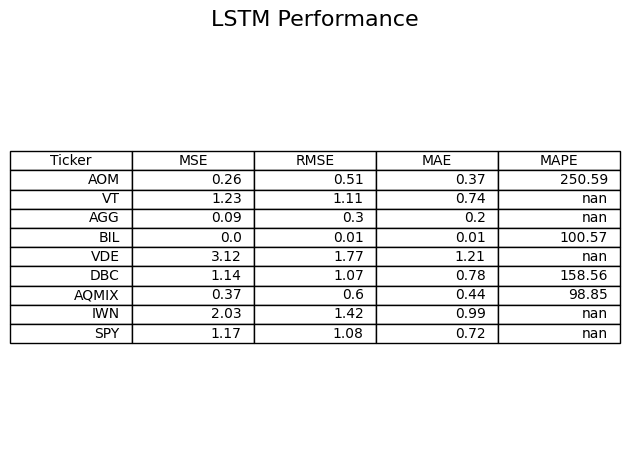

In [ ]:
lstm_res = []
for keys, values in lstm_perf.items():
    row = {"Ticker": keys, **values['LSTM']}  # Unpacking values directly
    lstm_res.append(row)

df_lstm = pd.DataFrame(lstm_res).round(2)
df_lstm.to_csv('/content/drive/My Drive/lstm_model_performances.csv')
df_lstm.dropna(axis=1)

fig, ax = plt.subplots()
fig.patch.set_visible(False)
ax.axis('off')
ax.table(cellText=df_lstm.values, colLabels=df_lstm.columns, loc='center')
ax.set_title('LSTM Performance', fontsize=16)
fig.tight_layout()
plt.show()

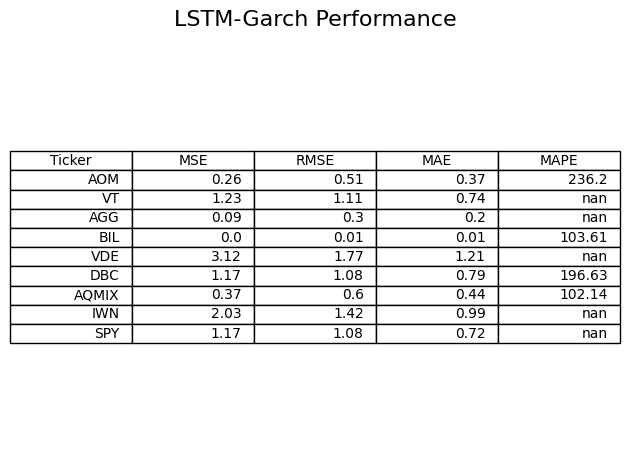

In [ ]:
hybrid_res = []
for keys, values in lstm_perf.items():
    row = {"Ticker": keys, **values['Hybrid']}  # Unpacking values directly
    hybrid_res.append(row)

df_hybrid = pd.DataFrame(hybrid_res).round(2)
df_hybrid.to_csv('/content/drive/My Drive/hybrid_model_performances.csv')
df_hybrid.dropna(axis=1)

fig, ax = plt.subplots()
fig.patch.set_visible(False)
ax.axis('off')
ax.table(cellText=df_hybrid.values, colLabels=df_hybrid.columns, loc='center')
ax.set_title('LSTM-Garch Performance', fontsize=16)
fig.tight_layout()
plt.show()

In [ ]:
lstm_vol = {}

for ticker in tickers:
    if ticker != '^VIX':
        lstm_pred = pred_lstm[ticker]["Predicted"].rename("LSTM_Pred")
        lstm_actual = pred_lstm[ticker]["Actual"].rename("LSTM_Act")
        hybrid_pred = pred_lstm_garch[ticker]["Predicted"].rename("Hybrid_Pred")
        hybrid_actual = pred_lstm_garch[ticker]["Actual"].rename("Hybrid_Act")

        df = pd.DataFrame({"Date": lstm_pred.index, "Ticker": ticker, "LSTM_Pred": lstm_pred, "LSTM_Actual": lstm_actual,
            "Hybrid_Pred": hybrid_pred, "Hybrid_Actual": hybrid_actual})
        lstm_vol[ticker] = df

lstm_vol_df = pd.concat(lstm_vol.values(), ignore_index=True)
lstm_vol_df.to_csv("/content/drive/My Drive/lstm_hybrid_forecast.csv", index=False)

In [ ]:
# Define the best hyperparameters based on the given values
best_hp_values = {
    'n_dropout': 0.1,
    'learning_rate': 0.0005,
    'units_LSTM_0': 16,
    'num_lstm': 1,
    'num_dense': 2,
    'units_LSTM_1': 16
}

# Initialize dictionaries for storing predictions and performance metrics
pred_lstm = {}
pred_lstm_garch = {}
lstm_perf = {}

# Loop over each ticker to train and evaluate the model
for ticker in ['AGG','SPY']:
    ticker_df = globals()["lag_" + ticker]
    train_df, valid_df, test_df = split_dataset(ticker_df, train_size, valid_size)
    lstm_model_tuner.prepare_data(train_df, valid_df, test_df, target=ticker)

    model = Sequential()
    model.add(LSTM(units=best_hp_values['units_LSTM_0'], activation="tanh", return_sequences=True, input_shape=(lstm_model_tuner.X_train.shape[1], lstm_model_tuner.n_features)))

    for i in range(1, best_hp_values['num_lstm']):
        model.add(LSTM(units=best_hp_values['units_LSTM_1'], activation="tanh", return_sequences=True))
        model.add(Dropout(best_hp_values['n_dropout']))

    model.add(LSTM(units=8, activation="tanh", return_sequences=False))
    model.add(Dropout(best_hp_values['n_dropout'], seed=lstm_model_tuner.seed))

    for i in range(1, best_hp_values['num_dense']):
        model.add(Dense(units=16, activation=lstm_model_tuner.act_fun))
        model.add(Dropout(best_hp_values['n_dropout']))
    model.add(Dense(1))

    adam = tf.keras.optimizers.Adam(learning_rate=best_hp_values['learning_rate'])
    model.compile(optimizer=adam, loss="mean_absolute_error")

    es = EarlyStopping(monitor='val_loss', mode='min', patience=20, restore_best_weights=True)
    model.fit(lstm_model_tuner.X_train, lstm_model_tuner.y_train, validation_data=(lstm_model_tuner.X_valid, lstm_model_tuner.y_valid),
              epochs=100, batch_size=32, verbose=0, callbacks=[es])

    lstm_model_tuner.model = model
    lstm_model_tuner.evaluate()

    pred_lstm[ticker], LSTM_perf = lstm_model_tuner.predict(ticker, model="LSTM", test_df=test_df)
    if ticker not in lstm_perf:
        lstm_perf[ticker] = {}
    lstm_perf[ticker]["LSTM"] = LSTM_perf

    ticker_garch_df = pd.merge(ticker_df, egarch_vol[ticker].to_frame(), on='Date', how='inner')
    train_garch, valid_garch, test_garch = split_dataset(ticker_garch_df, train_size, valid_size)
    lstm_model_tuner.prepare_data(train_garch, valid_garch, test_garch, target=ticker)
    model = Sequential()
    model.add(LSTM(units=best_hp_values['units_LSTM_0'], activation="tanh", return_sequences=True, input_shape=(lstm_model_tuner.X_train.shape[1], lstm_model_tuner.n_features)))

    for i in range(1, best_hp_values['num_lstm']):
        model.add(LSTM(units=best_hp_values['units_LSTM_1'], activation="tanh", return_sequences=True))
        model.add(Dropout(best_hp_values['n_dropout']))

    model.add(LSTM(units=8, activation="tanh", return_sequences=False))
    model.add(Dropout(best_hp_values['n_dropout'], seed=lstm_model_tuner.seed))

    for i in range(1, best_hp_values['num_dense']):
        model.add(Dense(units=16, activation=lstm_model_tuner.act_fun))
        model.add(Dropout(best_hp_values['n_dropout']))
    model.add(Dense(1))

    adam = tf.keras.optimizers.Adam(learning_rate=best_hp_values['learning_rate'])
    model.compile(optimizer=adam, loss="mean_absolute_error")

    model.fit(lstm_model_tuner.X_train, lstm_model_tuner.y_train, validation_data=(lstm_model_tuner.X_valid, lstm_model_tuner.y_valid),
              epochs=100, batch_size=32, verbose=0, callbacks=[es])

    lstm_model_tuner.model = model
    lstm_model_tuner.evaluate()
    pred_lstm_garch[ticker], Hybrid_perf = lstm_model_tuner.predict(ticker, model="Hybrid", test_df=test_garch)
    lstm_perf[ticker]["Hybrid"] = Hybrid_perf

# Print the performance metrics
print(lstm_perf)